# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Fire up Turi Create

Make sure you have the latest version of Turi Create

In [1]:
import turicreate
import numpy as np

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = turicreate.SFrame('~/my-env/1_Regression/data/home_data.sframe/')

If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# Import useful functions from previous notebook

As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [3]:
import numpy as np # note this allows us to refer to numpy as np instead 

In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [5]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [6]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant:
        derivative = 2 * sum(errors*feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = (2 * sum(errors*feature)) + (2*l2_penalty*weight)
    return derivative

To test your feature derivartive run the following:

In [7]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print (np.sum(errors*example_features[:,1])*2+20.)
print ('')

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print (np.sum(errors)*2.)

-56554166782350.0
-56554166782350.0

-22446749336.0
-22446749336.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [8]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print ('Starting gradient descent with l2_penalty = ' + str(l2_penalty))
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration < max_iterations:
        iteration += 1  # increment iteration counter
    ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        ### === end code section ===

        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print ('Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2)))

        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i ==0:
                derivative=feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, True)
            else:
                derivative=feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, False)
            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - step_size * derivative
            print ('Done with gradient descent at iteration ', iteration)
            print ('Learned weights = ', str(weights))
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [9]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [10]:
train_data,test_data = sales.random_split(.8,seed=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [11]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [12]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [13]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 0.0, max_iterations)

Starting gradient descent with l2_penalty = 0.0
Iteration = 1
Cost function =  7433051851026171.0
Done with gradient descent at iteration  1
Learned weights =  [0.0187527 0.       ]
Done with gradient descent at iteration  1
Learned weights =  [1.87526989e-02 4.73325137e+01]
Iteration = 2
Cost function =  5394267213135526.0
Done with gradient descent at iteration  2
Learned weights =  [3.40823824e-02 4.73325137e+01]
Done with gradient descent at iteration  2
Learned weights =  [3.40823824e-02 8.61473080e+01]
Iteration = 3
Cost function =  4023237736501162.0
Done with gradient descent at iteration  3
Learned weights =  [4.6605039e-02 8.6147308e+01]
Done with gradient descent at iteration  3
Learned weights =  [4.66050390e-02 1.17977189e+02]
Iteration = 4
Cost function =  3101256183922412.5
Done with gradient descent at iteration  4
Learned weights =  [5.68258070e-02 1.17977189e+02]
Done with gradient descent at iteration  4
Learned weights =  [5.68258070e-02 1.44079125e+02]
Iteration = 

Done with gradient descent at iteration  53
Learned weights =  [9.14514426e-02 2.63015566e+02]
Done with gradient descent at iteration  53
Learned weights =  [9.14514426e-02 2.63017132e+02]
Done with gradient descent at iteration  54
Learned weights =  [9.11831428e-02 2.63017132e+02]
Done with gradient descent at iteration  54
Learned weights =  [9.11831428e-02 2.63018416e+02]
Done with gradient descent at iteration  55
Learned weights =  [9.09147502e-02 2.63018416e+02]
Done with gradient descent at iteration  55
Learned weights =  [9.09147502e-02 2.63019469e+02]
Done with gradient descent at iteration  56
Learned weights =  [9.06462815e-02 2.63019469e+02]
Done with gradient descent at iteration  56
Learned weights =  [9.06462815e-02 2.63020332e+02]
Done with gradient descent at iteration  57
Learned weights =  [9.03777503e-02 2.63020332e+02]
Done with gradient descent at iteration  57
Learned weights =  [9.03777503e-02 2.63021040e+02]
Done with gradient descent at iteration  58
Learne

Done with gradient descent at iteration  106
Learned weights =  [7.72070782e-02 2.63024272e+02]
Done with gradient descent at iteration  106
Learned weights =  [7.72070782e-02 2.63024272e+02]
Done with gradient descent at iteration  107
Learned weights =  [7.69382626e-02 2.63024272e+02]
Done with gradient descent at iteration  107
Learned weights =  [7.69382626e-02 2.63024272e+02]
Done with gradient descent at iteration  108
Learned weights =  [7.66694469e-02 2.63024272e+02]
Done with gradient descent at iteration  108
Learned weights =  [7.66694469e-02 2.63024272e+02]
Done with gradient descent at iteration  109
Learned weights =  [7.64006313e-02 2.63024272e+02]
Done with gradient descent at iteration  109
Learned weights =  [7.64006313e-02 2.63024273e+02]
Done with gradient descent at iteration  110
Learned weights =  [7.61318156e-02 2.63024273e+02]
Done with gradient descent at iteration  110
Learned weights =  [7.61318156e-02 2.63024273e+02]
Done with gradient descent at iteration 

Done with gradient descent at iteration  161
Learned weights =  [6.24222198e-02 2.63024278e+02]
Done with gradient descent at iteration  162
Learned weights =  [6.21534042e-02 2.63024278e+02]
Done with gradient descent at iteration  162
Learned weights =  [6.21534042e-02 2.63024278e+02]
Done with gradient descent at iteration  163
Learned weights =  [6.18845887e-02 2.63024278e+02]
Done with gradient descent at iteration  163
Learned weights =  [6.18845887e-02 2.63024278e+02]
Done with gradient descent at iteration  164
Learned weights =  [6.16157731e-02 2.63024278e+02]
Done with gradient descent at iteration  164
Learned weights =  [6.16157731e-02 2.63024279e+02]
Done with gradient descent at iteration  165
Learned weights =  [6.13469576e-02 2.63024279e+02]
Done with gradient descent at iteration  165
Learned weights =  [6.13469576e-02 2.63024279e+02]
Done with gradient descent at iteration  166
Learned weights =  [6.10781420e-02 2.63024279e+02]
Done with gradient descent at iteration 

Done with gradient descent at iteration  215
Learned weights =  [4.79061815e-02 2.63024284e+02]
Done with gradient descent at iteration  216
Learned weights =  [4.76373660e-02 2.63024284e+02]
Done with gradient descent at iteration  216
Learned weights =  [4.76373660e-02 2.63024284e+02]
Done with gradient descent at iteration  217
Learned weights =  [4.73685505e-02 2.63024284e+02]
Done with gradient descent at iteration  217
Learned weights =  [4.73685505e-02 2.63024284e+02]
Done with gradient descent at iteration  218
Learned weights =  [4.70997350e-02 2.63024284e+02]
Done with gradient descent at iteration  218
Learned weights =  [4.70997350e-02 2.63024284e+02]
Done with gradient descent at iteration  219
Learned weights =  [4.68309195e-02 2.63024284e+02]
Done with gradient descent at iteration  219
Learned weights =  [4.68309195e-02 2.63024285e+02]
Done with gradient descent at iteration  220
Learned weights =  [4.65621041e-02 2.63024285e+02]
Done with gradient descent at iteration 

Done with gradient descent at iteration  270
Learned weights =  [3.31213322e-02 2.63024290e+02]
Done with gradient descent at iteration  270
Learned weights =  [3.31213322e-02 2.63024290e+02]
Done with gradient descent at iteration  271
Learned weights =  [3.28525168e-02 2.63024290e+02]
Done with gradient descent at iteration  271
Learned weights =  [3.28525168e-02 2.63024290e+02]
Done with gradient descent at iteration  272
Learned weights =  [3.25837014e-02 2.63024290e+02]
Done with gradient descent at iteration  272
Learned weights =  [3.25837014e-02 2.63024290e+02]
Done with gradient descent at iteration  273
Learned weights =  [3.2314886e-02 2.6302429e+02]
Done with gradient descent at iteration  273
Learned weights =  [3.2314886e-02 2.6302429e+02]
Done with gradient descent at iteration  274
Learned weights =  [3.20460706e-02 2.63024290e+02]
Done with gradient descent at iteration  274
Learned weights =  [3.20460706e-02 2.63024290e+02]
Done with gradient descent at iteration  275

Done with gradient descent at iteration  325
Learned weights =  [1.83364876e-02 2.63024296e+02]
Done with gradient descent at iteration  325
Learned weights =  [1.83364876e-02 2.63024296e+02]
Done with gradient descent at iteration  326
Learned weights =  [1.80676722e-02 2.63024296e+02]
Done with gradient descent at iteration  326
Learned weights =  [1.80676722e-02 2.63024296e+02]
Done with gradient descent at iteration  327
Learned weights =  [1.77988569e-02 2.63024296e+02]
Done with gradient descent at iteration  327
Learned weights =  [1.77988569e-02 2.63024296e+02]
Done with gradient descent at iteration  328
Learned weights =  [1.75300416e-02 2.63024296e+02]
Done with gradient descent at iteration  328
Learned weights =  [1.75300416e-02 2.63024296e+02]
Done with gradient descent at iteration  329
Learned weights =  [1.72612263e-02 2.63024296e+02]
Done with gradient descent at iteration  329
Learned weights =  [1.72612263e-02 2.63024296e+02]
Done with gradient descent at iteration 

Done with gradient descent at iteration  380
Learned weights =  [3.55164755e-03 2.63024302e+02]
Done with gradient descent at iteration  380
Learned weights =  [3.55164755e-03 2.63024302e+02]
Done with gradient descent at iteration  381
Learned weights =  [3.28283233e-03 2.63024302e+02]
Done with gradient descent at iteration  381
Learned weights =  [3.28283233e-03 2.63024302e+02]
Done with gradient descent at iteration  382
Learned weights =  [3.01401710e-03 2.63024302e+02]
Done with gradient descent at iteration  382
Learned weights =  [3.01401710e-03 2.63024302e+02]
Done with gradient descent at iteration  383
Learned weights =  [2.74520187e-03 2.63024302e+02]
Done with gradient descent at iteration  383
Learned weights =  [2.74520187e-03 2.63024302e+02]
Done with gradient descent at iteration  384
Learned weights =  [2.47638665e-03 2.63024302e+02]
Done with gradient descent at iteration  384
Learned weights =  [2.47638665e-03 2.63024302e+02]
Done with gradient descent at iteration 

Done with gradient descent at iteration  434
Learned weights =  [-1.09643727e-02  2.63024308e+02]
Done with gradient descent at iteration  434
Learned weights =  [-1.09643727e-02  2.63024308e+02]
Done with gradient descent at iteration  435
Learned weights =  [-1.12331878e-02  2.63024308e+02]
Done with gradient descent at iteration  435
Learned weights =  [-1.12331878e-02  2.63024308e+02]
Done with gradient descent at iteration  436
Learned weights =  [-1.15020029e-02  2.63024308e+02]
Done with gradient descent at iteration  436
Learned weights =  [-1.15020029e-02  2.63024308e+02]
Done with gradient descent at iteration  437
Learned weights =  [-1.17708181e-02  2.63024308e+02]
Done with gradient descent at iteration  437
Learned weights =  [-1.17708181e-02  2.63024308e+02]
Done with gradient descent at iteration  438
Learned weights =  [-1.20396332e-02  2.63024308e+02]
Done with gradient descent at iteration  438
Learned weights =  [-1.20396332e-02  2.63024308e+02]
Done with gradient d

Done with gradient descent at iteration  488
Learned weights =  [-2.54803884e-02  2.63024313e+02]
Done with gradient descent at iteration  488
Learned weights =  [-2.54803884e-02  2.63024314e+02]
Done with gradient descent at iteration  489
Learned weights =  [-2.57492035e-02  2.63024314e+02]
Done with gradient descent at iteration  489
Learned weights =  [-2.57492035e-02  2.63024314e+02]
Done with gradient descent at iteration  490
Learned weights =  [-2.60180185e-02  2.63024314e+02]
Done with gradient descent at iteration  490
Learned weights =  [-2.60180185e-02  2.63024314e+02]
Done with gradient descent at iteration  491
Learned weights =  [-2.62868336e-02  2.63024314e+02]
Done with gradient descent at iteration  491
Learned weights =  [-2.62868336e-02  2.63024314e+02]
Done with gradient descent at iteration  492
Learned weights =  [-2.65556486e-02  2.63024314e+02]
Done with gradient descent at iteration  492
Learned weights =  [-2.65556486e-02  2.63024314e+02]
Done with gradient d

Done with gradient descent at iteration  541
Learned weights =  [-3.97275847e-02  2.63024319e+02]
Done with gradient descent at iteration  542
Learned weights =  [-3.99963997e-02  2.63024319e+02]
Done with gradient descent at iteration  542
Learned weights =  [-3.99963997e-02  2.63024319e+02]
Done with gradient descent at iteration  543
Learned weights =  [-4.02652146e-02  2.63024319e+02]
Done with gradient descent at iteration  543
Learned weights =  [-4.02652146e-02  2.63024320e+02]
Done with gradient descent at iteration  544
Learned weights =  [-4.05340296e-02  2.63024320e+02]
Done with gradient descent at iteration  544
Learned weights =  [-4.05340296e-02  2.63024320e+02]
Done with gradient descent at iteration  545
Learned weights =  [-4.08028446e-02  2.63024320e+02]
Done with gradient descent at iteration  545
Learned weights =  [-4.08028446e-02  2.63024320e+02]
Done with gradient descent at iteration  546
Learned weights =  [-4.10716596e-02  2.63024320e+02]
Done with gradient d

Done with gradient descent at iteration  596
Learned weights =  [-5.45124064e-02  2.63024325e+02]
Done with gradient descent at iteration  597
Learned weights =  [-5.47812213e-02  2.63024325e+02]
Done with gradient descent at iteration  597
Learned weights =  [-5.47812213e-02  2.63024325e+02]
Done with gradient descent at iteration  598
Learned weights =  [-5.50500362e-02  2.63024325e+02]
Done with gradient descent at iteration  598
Learned weights =  [-5.50500362e-02  2.63024325e+02]
Done with gradient descent at iteration  599
Learned weights =  [-5.53188511e-02  2.63024325e+02]
Done with gradient descent at iteration  599
Learned weights =  [-5.53188511e-02  2.63024326e+02]
Iteration = 600
Cost function =  1208251101470335.0
Done with gradient descent at iteration  600
Learned weights =  [-5.55876660e-02  2.63024326e+02]
Done with gradient descent at iteration  600
Learned weights =  [-5.55876660e-02  2.63024326e+02]
Done with gradient descent at iteration  601
Learned weights =  [-

Done with gradient descent at iteration  649
Learned weights =  [-6.87595940e-02  2.63024331e+02]
Done with gradient descent at iteration  650
Learned weights =  [-6.90284088e-02  2.63024331e+02]
Done with gradient descent at iteration  650
Learned weights =  [-6.90284088e-02  2.63024331e+02]
Done with gradient descent at iteration  651
Learned weights =  [-6.92972236e-02  2.63024331e+02]
Done with gradient descent at iteration  651
Learned weights =  [-6.92972236e-02  2.63024331e+02]
Done with gradient descent at iteration  652
Learned weights =  [-6.95660384e-02  2.63024331e+02]
Done with gradient descent at iteration  652
Learned weights =  [-6.95660384e-02  2.63024331e+02]
Done with gradient descent at iteration  653
Learned weights =  [-6.98348532e-02  2.63024331e+02]
Done with gradient descent at iteration  653
Learned weights =  [-6.98348532e-02  2.63024331e+02]
Done with gradient descent at iteration  654
Learned weights =  [-7.01036680e-02  2.63024331e+02]
Done with gradient d

Done with gradient descent at iteration  704
Learned weights =  [-8.35444066e-02  2.63024337e+02]
Done with gradient descent at iteration  705
Learned weights =  [-8.38132213e-02  2.63024337e+02]
Done with gradient descent at iteration  705
Learned weights =  [-8.38132213e-02  2.63024337e+02]
Done with gradient descent at iteration  706
Learned weights =  [-8.40820361e-02  2.63024337e+02]
Done with gradient descent at iteration  706
Learned weights =  [-8.40820361e-02  2.63024337e+02]
Done with gradient descent at iteration  707
Learned weights =  [-8.43508508e-02  2.63024337e+02]
Done with gradient descent at iteration  707
Learned weights =  [-8.43508508e-02  2.63024337e+02]
Done with gradient descent at iteration  708
Learned weights =  [-8.46196655e-02  2.63024337e+02]
Done with gradient descent at iteration  708
Learned weights =  [-8.46196655e-02  2.63024337e+02]
Done with gradient descent at iteration  709
Learned weights =  [-8.48884803e-02  2.63024337e+02]
Done with gradient d

Done with gradient descent at iteration  758
Learned weights =  [-9.80604000e-02  2.63024343e+02]
Done with gradient descent at iteration  759
Learned weights =  [-9.83292146e-02  2.63024343e+02]
Done with gradient descent at iteration  759
Learned weights =  [-9.83292146e-02  2.63024343e+02]
Done with gradient descent at iteration  760
Learned weights =  [-9.85980293e-02  2.63024343e+02]
Done with gradient descent at iteration  760
Learned weights =  [-9.85980293e-02  2.63024343e+02]
Done with gradient descent at iteration  761
Learned weights =  [-9.88668439e-02  2.63024343e+02]
Done with gradient descent at iteration  761
Learned weights =  [-9.88668439e-02  2.63024343e+02]
Done with gradient descent at iteration  762
Learned weights =  [-9.91356586e-02  2.63024343e+02]
Done with gradient descent at iteration  762
Learned weights =  [-9.91356586e-02  2.63024343e+02]
Done with gradient descent at iteration  763
Learned weights =  [-9.94044732e-02  2.63024343e+02]
Done with gradient d

Done with gradient descent at iteration  813
Learned weights =  [-1.12845203e-01  2.63024349e+02]
Done with gradient descent at iteration  814
Learned weights =  [-1.13114018e-01  2.63024349e+02]
Done with gradient descent at iteration  814
Learned weights =  [-1.13114018e-01  2.63024349e+02]
Done with gradient descent at iteration  815
Learned weights =  [-1.13382833e-01  2.63024349e+02]
Done with gradient descent at iteration  815
Learned weights =  [-1.13382833e-01  2.63024349e+02]
Done with gradient descent at iteration  816
Learned weights =  [-1.13651647e-01  2.63024349e+02]
Done with gradient descent at iteration  816
Learned weights =  [-1.13651647e-01  2.63024349e+02]
Done with gradient descent at iteration  817
Learned weights =  [-1.13920462e-01  2.63024349e+02]
Done with gradient descent at iteration  817
Learned weights =  [-1.13920462e-01  2.63024349e+02]
Done with gradient descent at iteration  818
Learned weights =  [-1.14189276e-01  2.63024349e+02]
Done with gradient d

Done with gradient descent at iteration  866
Learned weights =  [-1.27092373e-01  2.63024354e+02]
Done with gradient descent at iteration  867
Learned weights =  [-1.27361188e-01  2.63024354e+02]
Done with gradient descent at iteration  867
Learned weights =  [-1.27361188e-01  2.63024355e+02]
Done with gradient descent at iteration  868
Learned weights =  [-1.27630002e-01  2.63024355e+02]
Done with gradient descent at iteration  868
Learned weights =  [-1.27630002e-01  2.63024355e+02]
Done with gradient descent at iteration  869
Learned weights =  [-1.27898817e-01  2.63024355e+02]
Done with gradient descent at iteration  869
Learned weights =  [-1.27898817e-01  2.63024355e+02]
Done with gradient descent at iteration  870
Learned weights =  [-1.28167631e-01  2.63024355e+02]
Done with gradient descent at iteration  870
Learned weights =  [-1.28167631e-01  2.63024355e+02]
Done with gradient descent at iteration  871
Learned weights =  [-1.28436446e-01  2.63024355e+02]
Done with gradient d

Done with gradient descent at iteration  921
Learned weights =  [-1.41877168e-01  2.63024360e+02]
Done with gradient descent at iteration  921
Learned weights =  [-1.41877168e-01  2.63024360e+02]
Done with gradient descent at iteration  922
Learned weights =  [-1.42145982e-01  2.63024360e+02]
Done with gradient descent at iteration  922
Learned weights =  [-1.42145982e-01  2.63024360e+02]
Done with gradient descent at iteration  923
Learned weights =  [-1.42414796e-01  2.63024360e+02]
Done with gradient descent at iteration  923
Learned weights =  [-1.42414796e-01  2.63024361e+02]
Done with gradient descent at iteration  924
Learned weights =  [-1.42683611e-01  2.63024361e+02]
Done with gradient descent at iteration  924
Learned weights =  [-1.42683611e-01  2.63024361e+02]
Done with gradient descent at iteration  925
Learned weights =  [-1.42952425e-01  2.63024361e+02]
Done with gradient descent at iteration  925
Learned weights =  [-1.42952425e-01  2.63024361e+02]
Done with gradient d

Done with gradient descent at iteration  969
Learned weights =  [-1.54780257e-01  2.63024366e+02]
Done with gradient descent at iteration  970
Learned weights =  [-1.55049071e-01  2.63024366e+02]
Done with gradient descent at iteration  970
Learned weights =  [-1.55049071e-01  2.63024366e+02]
Done with gradient descent at iteration  971
Learned weights =  [-1.55317886e-01  2.63024366e+02]
Done with gradient descent at iteration  971
Learned weights =  [-1.55317886e-01  2.63024366e+02]
Done with gradient descent at iteration  972
Learned weights =  [-1.55586700e-01  2.63024366e+02]
Done with gradient descent at iteration  972
Learned weights =  [-1.55586700e-01  2.63024366e+02]
Done with gradient descent at iteration  973
Learned weights =  [-1.55855514e-01  2.63024366e+02]
Done with gradient descent at iteration  973
Learned weights =  [-1.55855514e-01  2.63024366e+02]
Done with gradient descent at iteration  974
Learned weights =  [-1.56124329e-01  2.63024366e+02]
Done with gradient d

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [14]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 1e11, max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7433051851026171.0
Done with gradient descent at iteration  1
Learned weights =  [0.0187527 0.       ]
Done with gradient descent at iteration  1
Learned weights =  [1.87526989e-02 4.73325137e+01]
Iteration = 2
Cost function =  5618303898412631.0
Done with gradient descent at iteration  2
Learned weights =  [3.40823824e-02 4.73325137e+01]
Done with gradient descent at iteration  2
Learned weights =  [3.40823824e-02 7.66808053e+01]
Iteration = 3
Cost function =  4920613278115386.0
Done with gradient descent at iteration  3
Learned weights =  [4.72896420e-02 7.66808053e+01]
Done with gradient descent at iteration  3
Learned weights =  [4.72896420e-02 9.48780684e+01]
Iteration = 4
Cost function =  4652381942612288.0
Done with gradient descent at iteration  4
Learned weights =  [5.91809029e-02 9.48780684e+01]
Done with gradient descent at iteration  4
Learned weights =  [5.91809029e-02 1.06161191e+02]

Done with gradient descent at iteration  52
Learned weights =  [  0.5303826 124.5739356]
Done with gradient descent at iteration  52
Learned weights =  [  0.5303826  124.57393375]
Done with gradient descent at iteration  53
Learned weights =  [  0.54012629 124.57393375]
Done with gradient descent at iteration  53
Learned weights =  [  0.54012629 124.57393189]
Done with gradient descent at iteration  54
Learned weights =  [  0.54986997 124.57393189]
Done with gradient descent at iteration  54
Learned weights =  [  0.54986997 124.57393004]
Done with gradient descent at iteration  55
Learned weights =  [  0.55961366 124.57393004]
Done with gradient descent at iteration  55
Learned weights =  [  0.55961366 124.57392819]
Done with gradient descent at iteration  56
Learned weights =  [  0.56935734 124.57392819]
Done with gradient descent at iteration  56
Learned weights =  [  0.56935734 124.57392633]
Done with gradient descent at iteration  57
Learned weights =  [  0.57910102 124.57392633]
D

Done with gradient descent at iteration  106
Learned weights =  [  1.05654128 124.57383546]
Done with gradient descent at iteration  106
Learned weights =  [  1.05654128 124.5738336 ]
Done with gradient descent at iteration  107
Learned weights =  [  1.06628496 124.5738336 ]
Done with gradient descent at iteration  107
Learned weights =  [  1.06628496 124.57383175]
Done with gradient descent at iteration  108
Learned weights =  [  1.07602863 124.57383175]
Done with gradient descent at iteration  108
Learned weights =  [  1.07602863 124.57382989]
Done with gradient descent at iteration  109
Learned weights =  [  1.0857723  124.57382989]
Done with gradient descent at iteration  109
Learned weights =  [  1.0857723  124.57382804]
Done with gradient descent at iteration  110
Learned weights =  [  1.09551598 124.57382804]
Done with gradient descent at iteration  110
Learned weights =  [  1.09551598 124.57382619]
Done with gradient descent at iteration  111
Learned weights =  [  1.10525965 12

Done with gradient descent at iteration  158
Learned weights =  [  1.56321204 124.57373717]
Done with gradient descent at iteration  159
Learned weights =  [  1.57295571 124.57373717]
Done with gradient descent at iteration  159
Learned weights =  [  1.57295571 124.57373531]
Done with gradient descent at iteration  160
Learned weights =  [  1.58269937 124.57373531]
Done with gradient descent at iteration  160
Learned weights =  [  1.58269937 124.57373346]
Done with gradient descent at iteration  161
Learned weights =  [  1.59244303 124.57373346]
Done with gradient descent at iteration  161
Learned weights =  [  1.59244303 124.5737316 ]
Done with gradient descent at iteration  162
Learned weights =  [  1.60218669 124.5737316 ]
Done with gradient descent at iteration  162
Learned weights =  [  1.60218669 124.57372975]
Done with gradient descent at iteration  163
Learned weights =  [  1.61193036 124.57372975]
Done with gradient descent at iteration  163
Learned weights =  [  1.61193036 12

Done with gradient descent at iteration  209
Learned weights =  [  2.06013859 124.57364258]
Done with gradient descent at iteration  210
Learned weights =  [  2.06988225 124.57364258]
Done with gradient descent at iteration  210
Learned weights =  [  2.06988225 124.57364073]
Done with gradient descent at iteration  211
Learned weights =  [  2.0796259  124.57364073]
Done with gradient descent at iteration  211
Learned weights =  [  2.0796259  124.57363888]
Done with gradient descent at iteration  212
Learned weights =  [  2.08936955 124.57363888]
Done with gradient descent at iteration  212
Learned weights =  [  2.08936955 124.57363702]
Done with gradient descent at iteration  213
Learned weights =  [  2.0991132  124.57363702]
Done with gradient descent at iteration  213
Learned weights =  [  2.0991132  124.57363517]
Done with gradient descent at iteration  214
Learned weights =  [  2.10885686 124.57363517]
Done with gradient descent at iteration  214
Learned weights =  [  2.10885686 12

Done with gradient descent at iteration  262
Learned weights =  [  2.5765519  124.57354615]
Done with gradient descent at iteration  262
Learned weights =  [  2.5765519  124.57354429]
Done with gradient descent at iteration  263
Learned weights =  [  2.58629554 124.57354429]
Done with gradient descent at iteration  263
Learned weights =  [  2.58629554 124.57354244]
Done with gradient descent at iteration  264
Learned weights =  [  2.59603918 124.57354244]
Done with gradient descent at iteration  264
Learned weights =  [  2.59603918 124.57354058]
Done with gradient descent at iteration  265
Learned weights =  [  2.60578282 124.57354058]
Done with gradient descent at iteration  265
Learned weights =  [  2.60578282 124.57353873]
Done with gradient descent at iteration  266
Learned weights =  [  2.61552646 124.57353873]
Done with gradient descent at iteration  266
Learned weights =  [  2.61552646 124.57353688]
Done with gradient descent at iteration  267
Learned weights =  [  2.62527011 12

Done with gradient descent at iteration  316
Learned weights =  [  3.10270826 124.573446  ]
Done with gradient descent at iteration  316
Learned weights =  [  3.10270826 124.57344415]
Done with gradient descent at iteration  317
Learned weights =  [  3.11245189 124.57344415]
Done with gradient descent at iteration  317
Learned weights =  [  3.11245189 124.57344229]
Done with gradient descent at iteration  318
Learned weights =  [  3.12219552 124.57344229]
Done with gradient descent at iteration  318
Learned weights =  [  3.12219552 124.57344044]
Done with gradient descent at iteration  319
Learned weights =  [  3.13193915 124.57344044]
Done with gradient descent at iteration  319
Learned weights =  [  3.13193915 124.57343858]
Done with gradient descent at iteration  320
Learned weights =  [  3.14168278 124.57343858]
Done with gradient descent at iteration  320
Learned weights =  [  3.14168278 124.57343673]
Done with gradient descent at iteration  321
Learned weights =  [  3.15142641 12

Done with gradient descent at iteration  374
Learned weights =  [  3.6678385  124.57333658]
Done with gradient descent at iteration  375
Learned weights =  [  3.67758212 124.57333658]
Done with gradient descent at iteration  375
Learned weights =  [  3.67758212 124.57333473]
Done with gradient descent at iteration  376
Learned weights =  [  3.68732574 124.57333473]
Done with gradient descent at iteration  376
Learned weights =  [  3.68732574 124.57333287]
Done with gradient descent at iteration  377
Learned weights =  [  3.69706936 124.57333287]
Done with gradient descent at iteration  377
Learned weights =  [  3.69706936 124.57333102]
Done with gradient descent at iteration  378
Learned weights =  [  3.70681297 124.57333102]
Done with gradient descent at iteration  378
Learned weights =  [  3.70681297 124.57332917]
Done with gradient descent at iteration  379
Learned weights =  [  3.71655659 124.57332917]
Done with gradient descent at iteration  379
Learned weights =  [  3.71655659 12

Done with gradient descent at iteration  421
Learned weights =  [  4.12578836 124.57324942]
Done with gradient descent at iteration  422
Learned weights =  [  4.13553197 124.57324942]
Done with gradient descent at iteration  422
Learned weights =  [  4.13553197 124.57324757]
Done with gradient descent at iteration  423
Learned weights =  [  4.14527558 124.57324757]
Done with gradient descent at iteration  423
Learned weights =  [  4.14527558 124.57324571]
Done with gradient descent at iteration  424
Learned weights =  [  4.15501919 124.57324571]
Done with gradient descent at iteration  424
Learned weights =  [  4.15501919 124.57324386]
Done with gradient descent at iteration  425
Learned weights =  [  4.1647628  124.57324386]
Done with gradient descent at iteration  425
Learned weights =  [  4.1647628 124.573242 ]
Done with gradient descent at iteration  426
Learned weights =  [  4.17450641 124.573242  ]
Done with gradient descent at iteration  426
Learned weights =  [  4.17450641 124.

Done with gradient descent at iteration  469
Learned weights =  [  4.59348137 124.5731604 ]
Done with gradient descent at iteration  470
Learned weights =  [  4.60322497 124.5731604 ]
Done with gradient descent at iteration  470
Learned weights =  [  4.60322497 124.57315855]
Done with gradient descent at iteration  471
Learned weights =  [  4.61296857 124.57315855]
Done with gradient descent at iteration  471
Learned weights =  [  4.61296857 124.57315669]
Done with gradient descent at iteration  472
Learned weights =  [  4.62271217 124.57315669]
Done with gradient descent at iteration  472
Learned weights =  [  4.62271217 124.57315484]
Done with gradient descent at iteration  473
Learned weights =  [  4.63245577 124.57315484]
Done with gradient descent at iteration  473
Learned weights =  [  4.63245577 124.57315298]
Done with gradient descent at iteration  474
Learned weights =  [  4.64219937 124.57315298]
Done with gradient descent at iteration  474
Learned weights =  [  4.64219937 12

Done with gradient descent at iteration  515
Learned weights =  [  5.04168673 124.57307695]
Done with gradient descent at iteration  515
Learned weights =  [  5.04168673 124.57307509]
Done with gradient descent at iteration  516
Learned weights =  [  5.05143032 124.57307509]
Done with gradient descent at iteration  516
Learned weights =  [  5.05143032 124.57307324]
Done with gradient descent at iteration  517
Learned weights =  [  5.06117391 124.57307324]
Done with gradient descent at iteration  517
Learned weights =  [  5.06117391 124.57307138]
Done with gradient descent at iteration  518
Learned weights =  [  5.0709175  124.57307138]
Done with gradient descent at iteration  518
Learned weights =  [  5.0709175  124.57306953]
Done with gradient descent at iteration  519
Learned weights =  [  5.08066109 124.57306953]
Done with gradient descent at iteration  519
Learned weights =  [  5.08066109 124.57306768]
Done with gradient descent at iteration  520
Learned weights =  [  5.09040468 12

Done with gradient descent at iteration  563
Learned weights =  [  5.50937882 124.57298608]
Done with gradient descent at iteration  564
Learned weights =  [  5.5191224  124.57298608]
Done with gradient descent at iteration  564
Learned weights =  [  5.5191224  124.57298422]
Done with gradient descent at iteration  565
Learned weights =  [  5.52886598 124.57298422]
Done with gradient descent at iteration  565
Learned weights =  [  5.52886598 124.57298237]
Done with gradient descent at iteration  566
Learned weights =  [  5.53860956 124.57298237]
Done with gradient descent at iteration  566
Learned weights =  [  5.53860956 124.57298051]
Done with gradient descent at iteration  567
Learned weights =  [  5.54835314 124.57298051]
Done with gradient descent at iteration  567
Learned weights =  [  5.54835314 124.57297866]
Done with gradient descent at iteration  568
Learned weights =  [  5.55809672 124.57297866]
Done with gradient descent at iteration  568
Learned weights =  [  5.55809672 12

Done with gradient descent at iteration  609
Learned weights =  [  5.95758329 124.57290262]
Done with gradient descent at iteration  609
Learned weights =  [  5.95758329 124.57290077]
Done with gradient descent at iteration  610
Learned weights =  [  5.96732686 124.57290077]
Done with gradient descent at iteration  610
Learned weights =  [  5.96732686 124.57289891]
Done with gradient descent at iteration  611
Learned weights =  [  5.97707043 124.57289891]
Done with gradient descent at iteration  611
Learned weights =  [  5.97707043 124.57289706]
Done with gradient descent at iteration  612
Learned weights =  [  5.986814   124.57289706]
Done with gradient descent at iteration  612
Learned weights =  [  5.986814  124.5728952]
Done with gradient descent at iteration  613
Learned weights =  [  5.99655757 124.5728952 ]
Done with gradient descent at iteration  613
Learned weights =  [  5.99655757 124.57289335]
Done with gradient descent at iteration  614
Learned weights =  [  6.00630114 124.

Done with gradient descent at iteration  660
Learned weights =  [  6.45450514 124.57280619]
Done with gradient descent at iteration  661
Learned weights =  [  6.4642487  124.57280619]
Done with gradient descent at iteration  661
Learned weights =  [  6.4642487  124.57280433]
Done with gradient descent at iteration  662
Learned weights =  [  6.47399226 124.57280433]
Done with gradient descent at iteration  662
Learned weights =  [  6.47399226 124.57280248]
Done with gradient descent at iteration  663
Learned weights =  [  6.48373582 124.57280248]
Done with gradient descent at iteration  663
Learned weights =  [  6.48373582 124.57280062]
Done with gradient descent at iteration  664
Learned weights =  [  6.49347938 124.57280062]
Done with gradient descent at iteration  664
Learned weights =  [  6.49347938 124.57279877]
Done with gradient descent at iteration  665
Learned weights =  [  6.50322294 124.57279877]
Done with gradient descent at iteration  665
Learned weights =  [  6.50322294 12

Done with gradient descent at iteration  711
Learned weights =  [  6.95142645 124.57271346]
Done with gradient descent at iteration  711
Learned weights =  [  6.95142645 124.5727116 ]
Done with gradient descent at iteration  712
Learned weights =  [  6.96117   124.5727116]
Done with gradient descent at iteration  712
Learned weights =  [  6.96117    124.57270975]
Done with gradient descent at iteration  713
Learned weights =  [  6.97091355 124.57270975]
Done with gradient descent at iteration  713
Learned weights =  [  6.97091355 124.5727079 ]
Done with gradient descent at iteration  714
Learned weights =  [  6.9806571 124.5727079]
Done with gradient descent at iteration  714
Learned weights =  [  6.9806571  124.57270604]
Done with gradient descent at iteration  715
Learned weights =  [  6.99040065 124.57270604]
Done with gradient descent at iteration  715
Learned weights =  [  6.99040065 124.57270419]
Done with gradient descent at iteration  716
Learned weights =  [  7.0001442  124.57

Done with gradient descent at iteration  763
Learned weights =  [  7.45809077 124.57261517]
Done with gradient descent at iteration  764
Learned weights =  [  7.46783431 124.57261517]
Done with gradient descent at iteration  764
Learned weights =  [  7.46783431 124.57261331]
Done with gradient descent at iteration  765
Learned weights =  [  7.47757785 124.57261331]
Done with gradient descent at iteration  765
Learned weights =  [  7.47757785 124.57261146]
Done with gradient descent at iteration  766
Learned weights =  [  7.48732139 124.57261146]
Done with gradient descent at iteration  766
Learned weights =  [  7.48732139 124.57260961]
Done with gradient descent at iteration  767
Learned weights =  [  7.49706492 124.57260961]
Done with gradient descent at iteration  767
Learned weights =  [  7.49706492 124.57260775]
Done with gradient descent at iteration  768
Learned weights =  [  7.50680846 124.57260775]
Done with gradient descent at iteration  768
Learned weights =  [  7.50680846 12

Done with gradient descent at iteration  816
Learned weights =  [  7.97449806 124.57251688]
Done with gradient descent at iteration  817
Learned weights =  [  7.98424159 124.57251688]
Done with gradient descent at iteration  817
Learned weights =  [  7.98424159 124.57251502]
Done with gradient descent at iteration  818
Learned weights =  [  7.99398512 124.57251502]
Done with gradient descent at iteration  818
Learned weights =  [  7.99398512 124.57251317]
Done with gradient descent at iteration  819
Learned weights =  [  8.00372865 124.57251317]
Done with gradient descent at iteration  819
Learned weights =  [  8.00372865 124.57251132]
Done with gradient descent at iteration  820
Learned weights =  [  8.01347218 124.57251132]
Done with gradient descent at iteration  820
Learned weights =  [  8.01347218 124.57250946]
Done with gradient descent at iteration  821
Learned weights =  [  8.0232157  124.57250946]
Done with gradient descent at iteration  821
Learned weights =  [  8.0232157  12

Done with gradient descent at iteration  861
Learned weights =  [  8.41295664 124.57243343]
Done with gradient descent at iteration  862
Learned weights =  [  8.42270016 124.57243343]
Done with gradient descent at iteration  862
Learned weights =  [  8.42270016 124.57243157]
Done with gradient descent at iteration  863
Learned weights =  [  8.43244368 124.57243157]
Done with gradient descent at iteration  863
Learned weights =  [  8.43244368 124.57242972]
Done with gradient descent at iteration  864
Learned weights =  [  8.44218719 124.57242972]
Done with gradient descent at iteration  864
Learned weights =  [  8.44218719 124.57242786]
Done with gradient descent at iteration  865
Learned weights =  [  8.45193071 124.57242786]
Done with gradient descent at iteration  865
Learned weights =  [  8.45193071 124.57242601]
Done with gradient descent at iteration  866
Learned weights =  [  8.46167423 124.57242601]
Done with gradient descent at iteration  866
Learned weights =  [  8.46167423 12

Done with gradient descent at iteration  916
Learned weights =  [  8.94884989 124.57233328]
Done with gradient descent at iteration  916
Learned weights =  [  8.94884989 124.57233143]
Done with gradient descent at iteration  917
Learned weights =  [  8.95859339 124.57233143]
Done with gradient descent at iteration  917
Learned weights =  [  8.95859339 124.57232957]
Done with gradient descent at iteration  918
Learned weights =  [  8.9683369  124.57232957]
Done with gradient descent at iteration  918
Learned weights =  [  8.9683369  124.57232772]
Done with gradient descent at iteration  919
Learned weights =  [  8.97808041 124.57232772]
Done with gradient descent at iteration  919
Learned weights =  [  8.97808041 124.57232586]
Done with gradient descent at iteration  920
Learned weights =  [  8.98782392 124.57232586]
Done with gradient descent at iteration  920
Learned weights =  [  8.98782392 124.57232401]
Done with gradient descent at iteration  921
Learned weights =  [  8.99756742 12

Done with gradient descent at iteration  969
Learned weights =  [  9.46525552 124.57223314]
Done with gradient descent at iteration  970
Learned weights =  [  9.47499902 124.57223314]
Done with gradient descent at iteration  970
Learned weights =  [  9.47499902 124.57223128]
Done with gradient descent at iteration  971
Learned weights =  [  9.48474252 124.57223128]
Done with gradient descent at iteration  971
Learned weights =  [  9.48474252 124.57222943]
Done with gradient descent at iteration  972
Learned weights =  [  9.49448601 124.57222943]
Done with gradient descent at iteration  972
Learned weights =  [  9.49448601 124.57222757]
Done with gradient descent at iteration  973
Learned weights =  [  9.50422951 124.57222757]
Done with gradient descent at iteration  973
Learned weights =  [  9.50422951 124.57222572]
Done with gradient descent at iteration  974
Learned weights =  [  9.513973   124.57222572]
Done with gradient descent at iteration  974
Learned weights =  [  9.513973   12

This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

In [45]:
print (simple_feature_matrix[:,1:2])
#print (output.shape)
#print(simple_feature_matrix[:1],output)

[[1180.]
 [2570.]
 [ 770.]
 ...
 [1530.]
 [1600.]
 [1020.]]


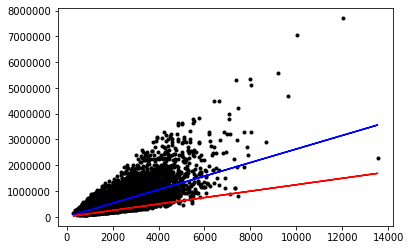

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix[:,1:2],output,'k.',
         simple_feature_matrix[:,1:2],predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix[:,1:2],predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [67]:
sum((predict_output(simple_feature_matrix, simple_weights_0_penalty)-output)**2)/1e15

1.2082510724935533

In [68]:
sum((predict_output(simple_feature_matrix, simple_weights_high_penalty)-output)**2)/1e15

2.932933001588834

In [69]:
sum((predict_output(simple_feature_matrix, [0,0])-output)**2)/1e15

7.433051851026171

In [92]:
sum((predict_output(simple_test_feature_matrix,simple_weights_0_penalty )-test_output)**2)/1e14

2.757236345975463

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
: no reg 263.0
: high reg 124.6

2. Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?
: no reg is steeper
3. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
: initial 7.43 * 1e15
: no 1.208 * 1e15
: high 2.93 * 1e15

In [66]:
print (simple_weights_0_penalty)
print (simple_weights_high_penalty)

[-1.63113501e-01  2.63024369e+02]
[  9.76730383 124.57217565]


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [70]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [71]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [73]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 0, max_iterations)

Starting gradient descent with l2_penalty = 0
Iteration = 1
Cost function =  7433051851026171.0
Done with gradient descent at iteration  1
Learned weights =  [0.0187527 0.        0.       ]
Done with gradient descent at iteration  1
Learned weights =  [1.87526989e-02 4.73325137e+01 0.00000000e+00]
Done with gradient descent at iteration  1
Learned weights =  [1.87526989e-02 4.73325137e+01 4.23911280e+01]
Iteration = 2
Cost function =  4056752331500973.0
Done with gradient descent at iteration  2
Learned weights =  [3.11553143e-02 4.73325137e+01 4.23911280e+01]
Done with gradient descent at iteration  2
Learned weights =  [3.11553143e-02 7.93537160e+01 4.23911280e+01]
Done with gradient descent at iteration  2
Learned weights =  [3.11553143e-02 7.93537160e+01 7.06890272e+01]
Iteration = 3
Cost function =  2529565114333587.0
Done with gradient descent at iteration  3
Learned weights =  [3.92882612e-02 7.93537160e+01 7.06890272e+01]
Done with gradient descent at iteration  3
Learned weigh

Done with gradient descent at iteration  32
Learned weights =  [3.94882265e-02 1.60130754e+02 1.12997677e+02]
Done with gradient descent at iteration  32
Learned weights =  [3.94882265e-02 1.60130754e+02 1.12458880e+02]
Done with gradient descent at iteration  33
Learned weights =  [3.88953321e-02 1.60130754e+02 1.12458880e+02]
Done with gradient descent at iteration  33
Learned weights =  [3.88953321e-02 1.60624317e+02 1.12458880e+02]
Done with gradient descent at iteration  33
Learned weights =  [3.88953321e-02 1.60624317e+02 1.11923215e+02]
Done with gradient descent at iteration  34
Learned weights =  [3.83037312e-02 1.60624317e+02 1.11923215e+02]
Done with gradient descent at iteration  34
Learned weights =  [3.83037312e-02 1.61114907e+02 1.11923215e+02]
Done with gradient descent at iteration  34
Learned weights =  [3.83037312e-02 1.61114907e+02 1.11390685e+02]
Done with gradient descent at iteration  35
Learned weights =  [3.77134222e-02 1.61114907e+02 1.11390685e+02]
Done with 

Done with gradient descent at iteration  67
Learned weights =  [1.94675476e-02 1.75767905e+02 9.54796495e+01]
Done with gradient descent at iteration  68
Learned weights =  [1.89161992e-02 1.75767905e+02 9.54796495e+01]
Done with gradient descent at iteration  68
Learned weights =  [1.89161992e-02 1.76168575e+02 9.54796495e+01]
Done with gradient descent at iteration  68
Learned weights =  [1.89161992e-02 1.76168575e+02 9.50445690e+01]
Done with gradient descent at iteration  69
Learned weights =  [1.83659169e-02 1.76168575e+02 9.50445690e+01]
Done with gradient descent at iteration  69
Learned weights =  [1.83659169e-02 1.76566868e+02 9.50445690e+01]
Done with gradient descent at iteration  69
Learned weights =  [1.83659169e-02 1.76566868e+02 9.46120692e+01]
Iteration = 70
Cost function =  1234403013463993.5
Done with gradient descent at iteration  70
Learned weights =  [1.78166944e-02 1.76566868e+02 9.46120692e+01]
Done with gradient descent at iteration  70
Learned weights =  [1.781

Done with gradient descent at iteration  102
Learned weights =  [7.65179847e-04 1.88465319e+02 8.20471572e+01]
Done with gradient descent at iteration  102
Learned weights =  [7.65179847e-04 1.88465319e+02 8.16917526e+01]
Done with gradient descent at iteration  103
Learned weights =  [2.47616102e-04 1.88465319e+02 8.16917526e+01]
Done with gradient descent at iteration  103
Learned weights =  [2.47616102e-04 1.88790674e+02 8.16917526e+01]
Done with gradient descent at iteration  103
Learned weights =  [2.47616102e-04 1.88790674e+02 8.13384561e+01]
Done with gradient descent at iteration  104
Learned weights =  [-2.69081957e-04  1.88790674e+02  8.13384561e+01]
Done with gradient descent at iteration  104
Learned weights =  [-2.69081957e-04  1.89114098e+02  8.13384561e+01]
Done with gradient descent at iteration  104
Learned weights =  [-2.69081957e-04  1.89114098e+02  8.09872552e+01]
Done with gradient descent at iteration  105
Learned weights =  [-7.84919464e-04  1.89114098e+02  8.098

Done with gradient descent at iteration  137
Learned weights =  [-1.68665380e-02  1.98510174e+02  7.07842243e+01]
Done with gradient descent at iteration  137
Learned weights =  [-1.68665380e-02  1.98775947e+02  7.07842243e+01]
Done with gradient descent at iteration  137
Learned weights =  [-1.68665380e-02  1.98775947e+02  7.04956266e+01]
Done with gradient descent at iteration  138
Learned weights =  [-1.73566677e-02  1.98775947e+02  7.04956266e+01]
Done with gradient descent at iteration  138
Learned weights =  [-1.73566677e-02  1.99040143e+02  7.04956266e+01]
Done with gradient descent at iteration  138
Learned weights =  [-1.73566677e-02  1.99040143e+02  7.02087408e+01]
Done with gradient descent at iteration  139
Learned weights =  [-1.78460945e-02  1.99040143e+02  7.02087408e+01]
Done with gradient descent at iteration  139
Learned weights =  [-1.78460945e-02  1.99302772e+02  7.02087408e+01]
Done with gradient descent at iteration  139
Learned weights =  [-1.78460945e-02  1.9930

Done with gradient descent at iteration  170
Learned weights =  [-3.26914288e-02  2.06715525e+02  6.21113348e+01]
Done with gradient descent at iteration  170
Learned weights =  [-3.26914288e-02  2.06715525e+02  6.18741810e+01]
Done with gradient descent at iteration  171
Learned weights =  [-3.31604333e-02  2.06715525e+02  6.18741810e+01]
Done with gradient descent at iteration  171
Learned weights =  [-3.31604333e-02  2.06932627e+02  6.18741810e+01]
Done with gradient descent at iteration  171
Learned weights =  [-3.31604333e-02  2.06932627e+02  6.16384340e+01]
Done with gradient descent at iteration  172
Learned weights =  [-3.36288602e-02  2.06932627e+02  6.16384340e+01]
Done with gradient descent at iteration  172
Learned weights =  [-3.36288602e-02  2.07148441e+02  6.16384340e+01]
Done with gradient descent at iteration  172
Learned weights =  [-3.36288602e-02  2.07148441e+02  6.14040853e+01]
Done with gradient descent at iteration  173
Learned weights =  [-3.40967128e-02  2.0714

Done with gradient descent at iteration  203
Learned weights =  [-4.78814674e-02  2.13239837e+02  5.47895495e+01]
Done with gradient descent at iteration  204
Learned weights =  [-4.83331124e-02  2.13239837e+02  5.47895495e+01]
Done with gradient descent at iteration  204
Learned weights =  [-4.83331124e-02  2.13418239e+02  5.47895495e+01]
Done with gradient descent at iteration  204
Learned weights =  [-4.83331124e-02  2.13418239e+02  5.45958255e+01]
Done with gradient descent at iteration  205
Learned weights =  [-4.87842827e-02  2.13418239e+02  5.45958255e+01]
Done with gradient descent at iteration  205
Learned weights =  [-4.87842827e-02  2.13595584e+02  5.45958255e+01]
Done with gradient descent at iteration  205
Learned weights =  [-4.87842827e-02  2.13595584e+02  5.44032506e+01]
Done with gradient descent at iteration  206
Learned weights =  [-4.92349811e-02  2.13595584e+02  5.44032506e+01]
Done with gradient descent at iteration  206
Learned weights =  [-4.92349811e-02  2.1377

Done with gradient descent at iteration  237
Learned weights =  [-6.29871989e-02  2.18601159e+02  4.89677878e+01]
Done with gradient descent at iteration  237
Learned weights =  [-6.29871989e-02  2.18747761e+02  4.89677878e+01]
Done with gradient descent at iteration  237
Learned weights =  [-6.29871989e-02  2.18747761e+02  4.88085960e+01]
Done with gradient descent at iteration  238
Learned weights =  [-6.34241887e-02  2.18747761e+02  4.88085960e+01]
Done with gradient descent at iteration  238
Learned weights =  [-6.34241887e-02  2.18893493e+02  4.88085960e+01]
Done with gradient descent at iteration  238
Learned weights =  [-6.34241887e-02  2.18893493e+02  4.86503485e+01]
Done with gradient descent at iteration  239
Learned weights =  [-6.38607907e-02  2.18893493e+02  4.86503485e+01]
Done with gradient descent at iteration  239
Learned weights =  [-6.38607907e-02  2.19038360e+02  4.86503485e+01]
Done with gradient descent at iteration  239
Learned weights =  [-6.38607907e-02  2.1903

Done with gradient descent at iteration  271
Learned weights =  [-7.76404711e-02  2.23127270e+02  4.40529683e+01]
Done with gradient descent at iteration  271
Learned weights =  [-7.76404711e-02  2.23247024e+02  4.40529683e+01]
Done with gradient descent at iteration  271
Learned weights =  [-7.76404711e-02  2.23247024e+02  4.39229292e+01]
Done with gradient descent at iteration  272
Learned weights =  [-7.80654894e-02  2.23247024e+02  4.39229292e+01]
Done with gradient descent at iteration  272
Learned weights =  [-7.80654894e-02  2.23366069e+02  4.39229292e+01]
Done with gradient descent at iteration  272
Learned weights =  [-7.80654894e-02  2.23366069e+02  4.37936614e+01]
Done with gradient descent at iteration  273
Learned weights =  [-7.84901910e-02  2.23366069e+02  4.37936614e+01]
Done with gradient descent at iteration  273
Learned weights =  [-7.84901910e-02  2.23484407e+02  4.37936614e+01]
Done with gradient descent at iteration  273
Learned weights =  [-7.84901910e-02  2.2348

Done with gradient descent at iteration  306
Learned weights =  [-9.23393813e-02  2.27019586e+02  3.99319703e+01]
Done with gradient descent at iteration  306
Learned weights =  [-9.23393813e-02  2.27019586e+02  3.98263752e+01]
Done with gradient descent at iteration  307
Learned weights =  [-9.27543617e-02  2.27019586e+02  3.98263752e+01]
Done with gradient descent at iteration  307
Learned weights =  [-9.27543617e-02  2.27116253e+02  3.98263752e+01]
Done with gradient descent at iteration  307
Learned weights =  [-9.27543617e-02  2.27116253e+02  3.97214065e+01]
Done with gradient descent at iteration  308
Learned weights =  [-9.31690850e-02  2.27116253e+02  3.97214065e+01]
Done with gradient descent at iteration  308
Learned weights =  [-9.31690850e-02  2.27212347e+02  3.97214065e+01]
Done with gradient descent at iteration  308
Learned weights =  [-9.31690850e-02  2.27212347e+02  3.96170604e+01]
Done with gradient descent at iteration  309
Learned weights =  [-9.35835525e-02  2.2721

Done with gradient descent at iteration  341
Learned weights =  [-1.06720187e-01  2.30083004e+02  3.65856150e+01]
Done with gradient descent at iteration  341
Learned weights =  [-1.06720187e-01  2.30083004e+02  3.64998691e+01]
Done with gradient descent at iteration  342
Learned weights =  [-1.07127016e-01  2.30083004e+02  3.64998691e+01]
Done with gradient descent at iteration  342
Learned weights =  [-1.07127016e-01  2.30161500e+02  3.64998691e+01]
Done with gradient descent at iteration  342
Learned weights =  [-1.07127016e-01  2.30161500e+02  3.64146318e+01]
Done with gradient descent at iteration  343
Learned weights =  [-1.07533637e-01  2.30161500e+02  3.64146318e+01]
Done with gradient descent at iteration  343
Learned weights =  [-1.07533637e-01  2.30239530e+02  3.64146318e+01]
Done with gradient descent at iteration  343
Learned weights =  [-1.07533637e-01  2.30239530e+02  3.63299001e+01]
Done with gradient descent at iteration  344
Learned weights =  [-1.07940050e-01  2.3023

Done with gradient descent at iteration  374
Learned weights =  [-1.20041749e-01  2.32441953e+02  3.39383327e+01]
Done with gradient descent at iteration  375
Learned weights =  [-1.20442301e-01  2.32441953e+02  3.39383327e+01]
Done with gradient descent at iteration  375
Learned weights =  [-1.20442301e-01  2.32506457e+02  3.39383327e+01]
Done with gradient descent at iteration  375
Learned weights =  [-1.20442301e-01  2.32506457e+02  3.38682894e+01]
Done with gradient descent at iteration  376
Learned weights =  [-1.20842683e-01  2.32506457e+02  3.38682894e+01]
Done with gradient descent at iteration  376
Learned weights =  [-1.20842683e-01  2.32570578e+02  3.38682894e+01]
Done with gradient descent at iteration  376
Learned weights =  [-1.20842683e-01  2.32570578e+02  3.37986616e+01]
Done with gradient descent at iteration  377
Learned weights =  [-1.21242893e-01  2.32570578e+02  3.37986616e+01]
Done with gradient descent at iteration  377
Learned weights =  [-1.21242893e-01  2.3263

Done with gradient descent at iteration  408
Learned weights =  [-1.33570082e-01  2.34380408e+02  3.18334031e+01]
Done with gradient descent at iteration  408
Learned weights =  [-1.33570082e-01  2.34433414e+02  3.18334031e+01]
Done with gradient descent at iteration  408
Learned weights =  [-1.33570082e-01  2.34433414e+02  3.17758454e+01]
Done with gradient descent at iteration  409
Learned weights =  [-1.33965336e-01  2.34433414e+02  3.17758454e+01]
Done with gradient descent at iteration  409
Learned weights =  [-1.33965336e-01  2.34486105e+02  3.17758454e+01]
Done with gradient descent at iteration  409
Learned weights =  [-1.33965336e-01  2.34486105e+02  3.17186291e+01]
Done with gradient descent at iteration  410
Learned weights =  [-1.34360450e-01  2.34486105e+02  3.17186291e+01]
Done with gradient descent at iteration  410
Learned weights =  [-1.34360450e-01  2.34538484e+02  3.17186291e+01]
Done with gradient descent at iteration  410
Learned weights =  [-1.34360450e-01  2.3453

Done with gradient descent at iteration  443
Learned weights =  [-1.47325747e-01  2.36060181e+02  3.00093731e+01]
Done with gradient descent at iteration  443
Learned weights =  [-1.47325747e-01  2.36103223e+02  3.00093731e+01]
Done with gradient descent at iteration  443
Learned weights =  [-1.47325747e-01  2.36103223e+02  2.99626348e+01]
Done with gradient descent at iteration  444
Learned weights =  [-1.47716558e-01  2.36103223e+02  2.99626348e+01]
Done with gradient descent at iteration  444
Learned weights =  [-1.47716558e-01  2.36146009e+02  2.99626348e+01]
Done with gradient descent at iteration  444
Learned weights =  [-1.47716558e-01  2.36146009e+02  2.99161737e+01]
Done with gradient descent at iteration  445
Learned weights =  [-1.48107255e-01  2.36146009e+02  2.99161737e+01]
Done with gradient descent at iteration  445
Learned weights =  [-1.48107255e-01  2.36188542e+02  2.99161737e+01]
Done with gradient descent at iteration  445
Learned weights =  [-1.48107255e-01  2.3618

Done with gradient descent at iteration  476
Learned weights =  [-1.60165926e-01  2.37353670e+02  2.86048010e+01]
Done with gradient descent at iteration  476
Learned weights =  [-1.60165926e-01  2.37389040e+02  2.86048010e+01]
Done with gradient descent at iteration  476
Learned weights =  [-1.60165926e-01  2.37389040e+02  2.85663940e+01]
Done with gradient descent at iteration  477
Learned weights =  [-1.60553316e-01  2.37389040e+02  2.85663940e+01]
Done with gradient descent at iteration  477
Learned weights =  [-1.60553316e-01  2.37424199e+02  2.85663940e+01]
Done with gradient descent at iteration  477
Learned weights =  [-1.60553316e-01  2.37424199e+02  2.85282149e+01]
Done with gradient descent at iteration  478
Learned weights =  [-1.60940612e-01  2.37424199e+02  2.85282149e+01]
Done with gradient descent at iteration  478
Learned weights =  [-1.60940612e-01  2.37459151e+02  2.85282149e+01]
Done with gradient descent at iteration  478
Learned weights =  [-1.60940612e-01  2.3745

Done with gradient descent at iteration  508
Learned weights =  [-1.72518634e-01  2.38416589e+02  2.74823504e+01]
Done with gradient descent at iteration  508
Learned weights =  [-1.72518634e-01  2.38416589e+02  2.74506014e+01]
Done with gradient descent at iteration  509
Learned weights =  [-1.72903290e-01  2.38416589e+02  2.74506014e+01]
Done with gradient descent at iteration  509
Learned weights =  [-1.72903290e-01  2.38445654e+02  2.74506014e+01]
Done with gradient descent at iteration  509
Learned weights =  [-1.72903290e-01  2.38445654e+02  2.74190407e+01]
Done with gradient descent at iteration  510
Learned weights =  [-1.73287868e-01  2.38445654e+02  2.74190407e+01]
Done with gradient descent at iteration  510
Learned weights =  [-1.73287868e-01  2.38474546e+02  2.74190407e+01]
Done with gradient descent at iteration  510
Learned weights =  [-1.73287868e-01  2.38474546e+02  2.73876671e+01]
Done with gradient descent at iteration  511
Learned weights =  [-1.73672369e-01  2.3847

Done with gradient descent at iteration  543
Learned weights =  [-1.85938432e-01  2.39313921e+02  2.64762094e+01]
Done with gradient descent at iteration  543
Learned weights =  [-1.85938432e-01  2.39337663e+02  2.64762094e+01]
Done with gradient descent at iteration  543
Learned weights =  [-1.85938432e-01  2.39337663e+02  2.64504283e+01]
Done with gradient descent at iteration  544
Learned weights =  [-1.86320637e-01  2.39337663e+02  2.64504283e+01]
Done with gradient descent at iteration  544
Learned weights =  [-1.86320637e-01  2.39361265e+02  2.64504283e+01]
Done with gradient descent at iteration  544
Learned weights =  [-1.86320637e-01  2.39361265e+02  2.64248003e+01]
Done with gradient descent at iteration  545
Learned weights =  [-1.86702779e-01  2.39361265e+02  2.64248003e+01]
Done with gradient descent at iteration  545
Learned weights =  [-1.86702779e-01  2.39384726e+02  2.64248003e+01]
Done with gradient descent at iteration  545
Learned weights =  [-1.86702779e-01  2.3938

Done with gradient descent at iteration  578
Learned weights =  [-1.99280564e-01  2.40085600e+02  2.56591980e+01]
Done with gradient descent at iteration  578
Learned weights =  [-1.99280564e-01  2.40085600e+02  2.56382632e+01]
Done with gradient descent at iteration  579
Learned weights =  [-1.99660779e-01  2.40085600e+02  2.56382632e+01]
Done with gradient descent at iteration  579
Learned weights =  [-1.99660779e-01  2.40104765e+02  2.56382632e+01]
Done with gradient descent at iteration  579
Learned weights =  [-1.99660779e-01  2.40104765e+02  2.56174525e+01]
Done with gradient descent at iteration  580
Learned weights =  [-2.00040943e-01  2.40104765e+02  2.56174525e+01]
Done with gradient descent at iteration  580
Learned weights =  [-2.00040943e-01  2.40123816e+02  2.56174525e+01]
Done with gradient descent at iteration  580
Learned weights =  [-2.00040943e-01  2.40123816e+02  2.55967653e+01]
Done with gradient descent at iteration  581
Learned weights =  [-2.00421056e-01  2.4012

Done with gradient descent at iteration  611
Learned weights =  [-2.11802305e-01  2.40661539e+02  2.50128658e+01]
Done with gradient descent at iteration  612
Learned weights =  [-2.12180988e-01  2.40661539e+02  2.50128658e+01]
Done with gradient descent at iteration  612
Learned weights =  [-2.12180988e-01  2.40677288e+02  2.50128658e+01]
Done with gradient descent at iteration  612
Learned weights =  [-2.12180988e-01  2.40677288e+02  2.49957648e+01]
Done with gradient descent at iteration  613
Learned weights =  [-2.12559628e-01  2.40677288e+02  2.49957648e+01]
Done with gradient descent at iteration  613
Learned weights =  [-2.12559628e-01  2.40692943e+02  2.49957648e+01]
Done with gradient descent at iteration  613
Learned weights =  [-2.12559628e-01  2.40692943e+02  2.49787652e+01]
Done with gradient descent at iteration  614
Learned weights =  [-2.12938227e-01  2.40692943e+02  2.49787652e+01]
Done with gradient descent at iteration  614
Learned weights =  [-2.12938227e-01  2.4070

Done with gradient descent at iteration  645
Learned weights =  [-2.24655416e-01  2.41147757e+02  2.44989494e+01]
Done with gradient descent at iteration  645
Learned weights =  [-2.24655416e-01  2.41147757e+02  2.44848967e+01]
Done with gradient descent at iteration  646
Learned weights =  [-2.25032804e-01  2.41147757e+02  2.44848967e+01]
Done with gradient descent at iteration  646
Learned weights =  [-2.25032804e-01  2.41160621e+02  2.44848967e+01]
Done with gradient descent at iteration  646
Learned weights =  [-2.25032804e-01  2.41160621e+02  2.44709274e+01]
Done with gradient descent at iteration  647
Learned weights =  [-2.25410159e-01  2.41160621e+02  2.44709274e+01]
Done with gradient descent at iteration  647
Learned weights =  [-2.25410159e-01  2.41173409e+02  2.44709274e+01]
Done with gradient descent at iteration  647
Learned weights =  [-2.25410159e-01  2.41173409e+02  2.44570410e+01]
Done with gradient descent at iteration  648
Learned weights =  [-2.25787479e-01  2.4117

Done with gradient descent at iteration  679
Learned weights =  [-2.37468583e-01  2.41534362e+02  2.40650942e+01]
Done with gradient descent at iteration  679
Learned weights =  [-2.37468583e-01  2.41544933e+02  2.40650942e+01]
Done with gradient descent at iteration  679
Learned weights =  [-2.37468583e-01  2.41544933e+02  2.40536150e+01]
Done with gradient descent at iteration  680
Learned weights =  [-2.37844915e-01  2.41544933e+02  2.40536150e+01]
Done with gradient descent at iteration  680
Learned weights =  [-2.37844915e-01  2.41555442e+02  2.40536150e+01]
Done with gradient descent at iteration  680
Learned weights =  [-2.37844915e-01  2.41555442e+02  2.40422040e+01]
Done with gradient descent at iteration  681
Learned weights =  [-2.38221219e-01  2.41555442e+02  2.40422040e+01]
Done with gradient descent at iteration  681
Learned weights =  [-2.38221219e-01  2.41565888e+02  2.40422040e+01]
Done with gradient descent at iteration  681
Learned weights =  [-2.38221219e-01  2.4156

Done with gradient descent at iteration  712
Learned weights =  [ -0.24987363 241.85205297  23.72012443]
Done with gradient descent at iteration  712
Learned weights =  [ -0.24987363 241.86074     23.72012443]
Done with gradient descent at iteration  712
Learned weights =  [ -0.24987363 241.86074     23.7106915 ]
Done with gradient descent at iteration  713
Learned weights =  [ -0.25024912 241.86074     23.7106915 ]
Done with gradient descent at iteration  713
Learned weights =  [ -0.25024912 241.8693755   23.7106915 ]
Done with gradient descent at iteration  713
Learned weights =  [ -0.25024912 241.8693755   23.70131453]
Done with gradient descent at iteration  714
Learned weights =  [ -0.25062459 241.8693755   23.70131453]
Done with gradient descent at iteration  714
Learned weights =  [ -0.25062459 241.87795978  23.70131453]
Done with gradient descent at iteration  714
Learned weights =  [ -0.25062459 241.87795978  23.69199317]
Done with gradient descent at iteration  715
Learned we

Done with gradient descent at iteration  744
Learned weights =  [ -0.26187861 242.11311421  23.44444576]
Done with gradient descent at iteration  744
Learned weights =  [ -0.26187861 242.11311421  23.43664807]
Done with gradient descent at iteration  745
Learned weights =  [ -0.26225343 242.11311421  23.43664807]
Done with gradient descent at iteration  745
Learned weights =  [ -0.26225343 242.12025274  23.43664807]
Done with gradient descent at iteration  745
Learned weights =  [ -0.26225343 242.12025274  23.42889664]
Done with gradient descent at iteration  746
Learned weights =  [ -0.26262823 242.12025274  23.42889664]
Done with gradient descent at iteration  746
Learned weights =  [ -0.26262823 242.12734892  23.42889664]
Done with gradient descent at iteration  746
Learned weights =  [ -0.26262823 242.12734892  23.42119118]
Done with gradient descent at iteration  747
Learned weights =  [ -0.26300301 242.12734892  23.42119118]
Done with gradient descent at iteration  747
Learned we

Done with gradient descent at iteration  802
Learned weights =  [ -0.28358997 242.45922701  23.06081972]
Done with gradient descent at iteration  802
Learned weights =  [ -0.28358997 242.46431254  23.06081972]
Done with gradient descent at iteration  802
Learned weights =  [ -0.28358997 242.46431254  23.05529759]
Done with gradient descent at iteration  803
Learned weights =  [ -0.28396385 242.46431254  23.05529759]
Done with gradient descent at iteration  803
Learned weights =  [ -0.28396385 242.46936791  23.05529759]
Done with gradient descent at iteration  803
Learned weights =  [ -0.28396385 242.46936791  23.04980822]
Done with gradient descent at iteration  804
Learned weights =  [ -0.28433772 242.46936791  23.04980822]
Done with gradient descent at iteration  804
Learned weights =  [ -0.28433772 242.4743933   23.04980822]
Done with gradient descent at iteration  804
Learned weights =  [ -0.28433772 242.4743933   23.04435141]
Done with gradient descent at iteration  805
Learned we

Done with gradient descent at iteration  836
Learned weights =  [ -0.29629498 242.61623575  22.89033234]
Done with gradient descent at iteration  836
Learned weights =  [ -0.29629498 242.62038998  22.89033234]
Done with gradient descent at iteration  836
Learned weights =  [ -0.29629498 242.62038998  22.8858215 ]
Done with gradient descent at iteration  837
Learned weights =  [ -0.29666845 242.62038998  22.8858215 ]
Done with gradient descent at iteration  837
Learned weights =  [ -0.29666845 242.62451957  22.8858215 ]
Done with gradient descent at iteration  837
Learned weights =  [ -0.29666845 242.62451957  22.88133742]
Done with gradient descent at iteration  838
Learned weights =  [ -0.29704191 242.62451957  22.88133742]
Done with gradient descent at iteration  838
Learned weights =  [ -0.29704191 242.62862466  22.88133742]
Done with gradient descent at iteration  838
Learned weights =  [ -0.29704191 242.62862466  22.87687994]
Done with gradient descent at iteration  839
Learned we

Done with gradient descent at iteration  870
Learned weights =  [ -0.30898716 242.74788517  22.75106712]
Done with gradient descent at iteration  870
Learned weights =  [ -0.30898716 242.74788517  22.74738237]
Done with gradient descent at iteration  871
Learned weights =  [ -0.30936029 242.74788517  22.74738237]
Done with gradient descent at iteration  871
Learned weights =  [ -0.30936029 242.75125851  22.74738237]
Done with gradient descent at iteration  871
Learned weights =  [ -0.30936029 242.75125851  22.74371949]
Done with gradient descent at iteration  872
Learned weights =  [ -0.30973342 242.75125851  22.74371949]
Done with gradient descent at iteration  872
Learned weights =  [ -0.30973342 242.75461184  22.74371949]
Done with gradient descent at iteration  872
Learned weights =  [ -0.30973342 242.75461184  22.74007833]
Done with gradient descent at iteration  873
Learned weights =  [ -0.31010653 242.75461184  22.74007833]
Done with gradient descent at iteration  873
Learned we

Done with gradient descent at iteration  900
Learned weights =  [ -0.32017739 242.84084459  22.6495268 ]
Done with gradient descent at iteration  900
Learned weights =  [ -0.32017739 242.84084459  22.64644438]
Done with gradient descent at iteration  901
Learned weights =  [ -0.32055027 242.84084459  22.64644438]
Done with gradient descent at iteration  901
Learned weights =  [ -0.32055027 242.84366653  22.64644438]
Done with gradient descent at iteration  901
Learned weights =  [ -0.32055027 242.84366653  22.64338024]
Done with gradient descent at iteration  902
Learned weights =  [ -0.32092315 242.84366653  22.64338024]
Done with gradient descent at iteration  902
Learned weights =  [ -0.32092315 242.84647174  22.64338024]
Done with gradient descent at iteration  902
Learned weights =  [ -0.32092315 242.84647174  22.64033428]
Done with gradient descent at iteration  903
Learned weights =  [ -0.32129602 242.84647174  22.64033428]
Done with gradient descent at iteration  903
Learned we

Done with gradient descent at iteration  935
Learned weights =  [ -0.33322411 242.92796824  22.551844  ]
Done with gradient descent at iteration  935
Learned weights =  [ -0.33322411 242.93027341  22.551844  ]
Done with gradient descent at iteration  935
Learned weights =  [ -0.33322411 242.93027341  22.54934103]
Done with gradient descent at iteration  936
Learned weights =  [ -0.33359676 242.93027341  22.54934103]
Done with gradient descent at iteration  936
Learned weights =  [ -0.33359676 242.9325649   22.54934103]
Done with gradient descent at iteration  936
Learned weights =  [ -0.33359676 242.9325649   22.5468529 ]
Done with gradient descent at iteration  937
Learned weights =  [ -0.3339694 242.9325649  22.5468529]
Done with gradient descent at iteration  937
Learned weights =  [ -0.3339694 242.9348428  22.5468529]
Done with gradient descent at iteration  937
Learned weights =  [ -0.3339694  242.9348428   22.54437953]
Done with gradient descent at iteration  938
Learned weights 

Done with gradient descent at iteration  968
Learned weights =  [ -0.34551838 242.99913707  22.47662547]
Done with gradient descent at iteration  968
Learned weights =  [ -0.34551838 242.99913707  22.47456869]
Done with gradient descent at iteration  969
Learned weights =  [ -0.34589084 242.99913707  22.47456869]
Done with gradient descent at iteration  969
Learned weights =  [ -0.34589084 243.0010201   22.47456869]
Done with gradient descent at iteration  969
Learned weights =  [ -0.34589084 243.0010201   22.47252412]
Done with gradient descent at iteration  970
Learned weights =  [ -0.3462633  243.0010201   22.47252412]
Done with gradient descent at iteration  970
Learned weights =  [ -0.3462633  243.00289195  22.47252412]
Done with gradient descent at iteration  970
Learned weights =  [ -0.3462633  243.00289195  22.47049166]
Done with gradient descent at iteration  971
Learned weights =  [ -0.34663575 243.00289195  22.47049166]
Done with gradient descent at iteration  971
Learned we

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [74]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 1e11, max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7433051851026171.0
Done with gradient descent at iteration  1
Learned weights =  [0.0187527 0.        0.       ]
Done with gradient descent at iteration  1
Learned weights =  [1.87526989e-02 4.73325137e+01 0.00000000e+00]
Done with gradient descent at iteration  1
Learned weights =  [1.87526989e-02 4.73325137e+01 4.23911280e+01]
Iteration = 2
Cost function =  4460489790285892.0
Done with gradient descent at iteration  2
Learned weights =  [3.11553143e-02 4.73325137e+01 4.23911280e+01]
Done with gradient descent at iteration  2
Learned weights =  [3.11553143e-02 6.98872133e+01 4.23911280e+01]
Done with gradient descent at iteration  2
Learned weights =  [3.11553143e-02 6.98872133e+01 6.22108016e+01]
Iteration = 3
Cost function =  3796674468844605.5
Done with gradient descent at iteration  3
Learned weights =  [4.05582778e-02 6.98872133e+01 6.22108016e+01]
Done with gradient descent at iteration  3


Done with gradient descent at iteration  33
Learned weights =  [ 0.24455347 91.48833207 78.43942988]
Done with gradient descent at iteration  33
Learned weights =  [ 0.24455347 91.48870387 78.43942988]
Done with gradient descent at iteration  33
Learned weights =  [ 0.24455347 91.48870387 78.43902427]
Done with gradient descent at iteration  34
Learned weights =  [ 0.25127369 91.48870387 78.43902427]
Done with gradient descent at iteration  34
Learned weights =  [ 0.25127369 91.48899892 78.43902427]
Done with gradient descent at iteration  34
Learned weights =  [ 0.25127369 91.48899892 78.43870201]
Done with gradient descent at iteration  35
Learned weights =  [ 0.25799392 91.48899892 78.43870201]
Done with gradient descent at iteration  35
Learned weights =  [ 0.25799392 91.48923302 78.43870201]
Done with gradient descent at iteration  35
Learned weights =  [ 0.25799392 91.48923302 78.43844592]
Done with gradient descent at iteration  36
Learned weights =  [ 0.26471415 91.48923302 78.

Done with gradient descent at iteration  68
Learned weights =  [ 0.47976142 91.49010912 78.43743357]
Done with gradient descent at iteration  68
Learned weights =  [ 0.47976142 91.49010912 78.43743254]
Done with gradient descent at iteration  69
Learned weights =  [ 0.48648165 91.49010912 78.43743254]
Done with gradient descent at iteration  69
Learned weights =  [ 0.48648165 91.49010832 78.43743254]
Done with gradient descent at iteration  69
Learned weights =  [ 0.48648165 91.49010832 78.43743153]
Iteration = 70
Cost function =  3605291727877070.0
Done with gradient descent at iteration  70
Learned weights =  [ 0.49320187 91.49010832 78.43743153]
Done with gradient descent at iteration  70
Learned weights =  [ 0.49320187 91.49010749 78.43743153]
Done with gradient descent at iteration  70
Learned weights =  [ 0.49320187 91.49010749 78.43743055]
Done with gradient descent at iteration  71
Learned weights =  [ 0.4999221  91.49010749 78.43743055]
Done with gradient descent at iteration 

Done with gradient descent at iteration  103
Learned weights =  [ 0.71496926 91.49007818 78.43740125]
Done with gradient descent at iteration  103
Learned weights =  [ 0.71496926 91.49007818 78.43740034]
Done with gradient descent at iteration  104
Learned weights =  [ 0.72168948 91.49007818 78.43740034]
Done with gradient descent at iteration  104
Learned weights =  [ 0.72168948 91.49007728 78.43740034]
Done with gradient descent at iteration  104
Learned weights =  [ 0.72168948 91.49007728 78.43739943]
Done with gradient descent at iteration  105
Learned weights =  [ 0.7284097  91.49007728 78.43739943]
Done with gradient descent at iteration  105
Learned weights =  [ 0.7284097  91.49007638 78.43739943]
Done with gradient descent at iteration  105
Learned weights =  [ 0.7284097  91.49007638 78.43739853]
Done with gradient descent at iteration  106
Learned weights =  [ 0.73512993 91.49007638 78.43739853]
Done with gradient descent at iteration  106
Learned weights =  [ 0.73512993 91.49

Done with gradient descent at iteration  136
Learned weights =  [ 0.93673653 91.49004858 78.43737044]
Done with gradient descent at iteration  137
Learned weights =  [ 0.94345675 91.49004858 78.43737044]
Done with gradient descent at iteration  137
Learned weights =  [ 0.94345675 91.49004768 78.43737044]
Done with gradient descent at iteration  137
Learned weights =  [ 0.94345675 91.49004768 78.43736954]
Done with gradient descent at iteration  138
Learned weights =  [ 0.95017697 91.49004768 78.43736954]
Done with gradient descent at iteration  138
Learned weights =  [ 0.95017697 91.49004678 78.43736954]
Done with gradient descent at iteration  138
Learned weights =  [ 0.95017697 91.49004678 78.43736863]
Done with gradient descent at iteration  139
Learned weights =  [ 0.95689719 91.49004678 78.43736863]
Done with gradient descent at iteration  139
Learned weights =  [ 0.95689719 91.49004589 78.43736863]
Done with gradient descent at iteration  139
Learned weights =  [ 0.95689719 91.49

Done with gradient descent at iteration  169
Learned weights =  [ 1.15850369 91.49001898 78.43734055]
Done with gradient descent at iteration  170
Learned weights =  [ 1.16522391 91.49001898 78.43734055]
Done with gradient descent at iteration  170
Learned weights =  [ 1.16522391 91.49001808 78.43734055]
Done with gradient descent at iteration  170
Learned weights =  [ 1.16522391 91.49001808 78.43733964]
Done with gradient descent at iteration  171
Learned weights =  [ 1.17194412 91.49001808 78.43733964]
Done with gradient descent at iteration  171
Learned weights =  [ 1.17194412 91.49001718 78.43733964]
Done with gradient descent at iteration  171
Learned weights =  [ 1.17194412 91.49001718 78.43733873]
Done with gradient descent at iteration  172
Learned weights =  [ 1.17866434 91.49001718 78.43733873]
Done with gradient descent at iteration  172
Learned weights =  [ 1.17866434 91.49001629 78.43733873]
Done with gradient descent at iteration  172
Learned weights =  [ 1.17866434 91.49

Done with gradient descent at iteration  205
Learned weights =  [ 1.40043137 91.48998759 78.43730884]
Done with gradient descent at iteration  205
Learned weights =  [ 1.40043137 91.48998669 78.43730884]
Done with gradient descent at iteration  205
Learned weights =  [ 1.40043137 91.48998669 78.43730793]
Done with gradient descent at iteration  206
Learned weights =  [ 1.40715158 91.48998669 78.43730793]
Done with gradient descent at iteration  206
Learned weights =  [ 1.40715158 91.48998579 78.43730793]
Done with gradient descent at iteration  206
Learned weights =  [ 1.40715158 91.48998579 78.43730702]
Done with gradient descent at iteration  207
Learned weights =  [ 1.41387179 91.48998579 78.43730702]
Done with gradient descent at iteration  207
Learned weights =  [ 1.41387179 91.48998489 78.43730702]
Done with gradient descent at iteration  207
Learned weights =  [ 1.41387179 91.48998489 78.43730612]
Done with gradient descent at iteration  208
Learned weights =  [ 1.420592   91.48

Done with gradient descent at iteration  238
Learned weights =  [ 1.62219828 91.48995709 78.43727894]
Done with gradient descent at iteration  238
Learned weights =  [ 1.62219828 91.48995709 78.43727803]
Done with gradient descent at iteration  239
Learned weights =  [ 1.62891849 91.48995709 78.43727803]
Done with gradient descent at iteration  239
Learned weights =  [ 1.62891849 91.48995619 78.43727803]
Done with gradient descent at iteration  239
Learned weights =  [ 1.62891849 91.48995619 78.43727713]
Done with gradient descent at iteration  240
Learned weights =  [ 1.6356387  91.48995619 78.43727713]
Done with gradient descent at iteration  240
Learned weights =  [ 1.6356387  91.48995529 78.43727713]
Done with gradient descent at iteration  240
Learned weights =  [ 1.6356387  91.48995529 78.43727622]
Done with gradient descent at iteration  241
Learned weights =  [ 1.64235891 91.48995529 78.43727622]
Done with gradient descent at iteration  241
Learned weights =  [ 1.64235891 91.48

Done with gradient descent at iteration  271
Learned weights =  [ 1.84396508 91.48992839 78.43724904]
Done with gradient descent at iteration  271
Learned weights =  [ 1.84396508 91.48992749 78.43724904]
Done with gradient descent at iteration  271
Learned weights =  [ 1.84396508 91.48992749 78.43724814]
Done with gradient descent at iteration  272
Learned weights =  [ 1.85068529 91.48992749 78.43724814]
Done with gradient descent at iteration  272
Learned weights =  [ 1.85068529 91.48992659 78.43724814]
Done with gradient descent at iteration  272
Learned weights =  [ 1.85068529 91.48992659 78.43724723]
Done with gradient descent at iteration  273
Learned weights =  [ 1.85740549 91.48992659 78.43724723]
Done with gradient descent at iteration  273
Learned weights =  [ 1.85740549 91.48992569 78.43724723]
Done with gradient descent at iteration  273
Learned weights =  [ 1.85740549 91.48992569 78.43724632]
Done with gradient descent at iteration  274
Learned weights =  [ 1.8641257  91.48

Done with gradient descent at iteration  303
Learned weights =  [ 2.05901157 91.48989968 78.43722005]
Done with gradient descent at iteration  303
Learned weights =  [ 2.05901157 91.48989879 78.43722005]
Done with gradient descent at iteration  303
Learned weights =  [ 2.05901157 91.48989879 78.43721915]
Done with gradient descent at iteration  304
Learned weights =  [ 2.06573177 91.48989879 78.43721915]
Done with gradient descent at iteration  304
Learned weights =  [ 2.06573177 91.48989789 78.43721915]
Done with gradient descent at iteration  304
Learned weights =  [ 2.06573177 91.48989789 78.43721824]
Done with gradient descent at iteration  305
Learned weights =  [ 2.07245197 91.48989789 78.43721824]
Done with gradient descent at iteration  305
Learned weights =  [ 2.07245197 91.48989699 78.43721824]
Done with gradient descent at iteration  305
Learned weights =  [ 2.07245197 91.48989699 78.43721733]
Done with gradient descent at iteration  306
Learned weights =  [ 2.07917217 91.48

Done with gradient descent at iteration  335
Learned weights =  [ 2.27405794 91.48987008 78.43719106]
Done with gradient descent at iteration  335
Learned weights =  [ 2.27405794 91.48987008 78.43719015]
Done with gradient descent at iteration  336
Learned weights =  [ 2.28077814 91.48987008 78.43719015]
Done with gradient descent at iteration  336
Learned weights =  [ 2.28077814 91.48986919 78.43719015]
Done with gradient descent at iteration  336
Learned weights =  [ 2.28077814 91.48986919 78.43718925]
Done with gradient descent at iteration  337
Learned weights =  [ 2.28749834 91.48986919 78.43718925]
Done with gradient descent at iteration  337
Learned weights =  [ 2.28749834 91.48986829 78.43718925]
Done with gradient descent at iteration  337
Learned weights =  [ 2.28749834 91.48986829 78.43718834]
Done with gradient descent at iteration  338
Learned weights =  [ 2.29421853 91.48986829 78.43718834]
Done with gradient descent at iteration  338
Learned weights =  [ 2.29421853 91.48

Done with gradient descent at iteration  367
Learned weights =  [ 2.48910421 91.48984138 78.43716116]
Done with gradient descent at iteration  368
Learned weights =  [ 2.4958244  91.48984138 78.43716116]
Done with gradient descent at iteration  368
Learned weights =  [ 2.4958244  91.48984048 78.43716116]
Done with gradient descent at iteration  368
Learned weights =  [ 2.4958244  91.48984048 78.43716026]
Done with gradient descent at iteration  369
Learned weights =  [ 2.5025446  91.48984048 78.43716026]
Done with gradient descent at iteration  369
Learned weights =  [ 2.5025446  91.48983959 78.43716026]
Done with gradient descent at iteration  369
Learned weights =  [ 2.5025446  91.48983959 78.43715935]
Done with gradient descent at iteration  370
Learned weights =  [ 2.50926479 91.48983959 78.43715935]
Done with gradient descent at iteration  370
Learned weights =  [ 2.50926479 91.48983869 78.43715935]
Done with gradient descent at iteration  370
Learned weights =  [ 2.50926479 91.48

Done with gradient descent at iteration  402
Learned weights =  [ 2.72431094 91.48981088 78.43713036]
Done with gradient descent at iteration  402
Learned weights =  [ 2.72431094 91.48980999 78.43713036]
Done with gradient descent at iteration  402
Learned weights =  [ 2.72431094 91.48980999 78.43712945]
Done with gradient descent at iteration  403
Learned weights =  [ 2.73103113 91.48980999 78.43712945]
Done with gradient descent at iteration  403
Learned weights =  [ 2.73103113 91.48980909 78.43712945]
Done with gradient descent at iteration  403
Learned weights =  [ 2.73103113 91.48980909 78.43712855]
Done with gradient descent at iteration  404
Learned weights =  [ 2.73775132 91.48980909 78.43712855]
Done with gradient descent at iteration  404
Learned weights =  [ 2.73775132 91.48980819 78.43712855]
Done with gradient descent at iteration  404
Learned weights =  [ 2.73775132 91.48980819 78.43712764]
Done with gradient descent at iteration  405
Learned weights =  [ 2.74447151 91.48

Done with gradient descent at iteration  435
Learned weights =  [ 2.94607716 91.48978039 78.43709956]
Done with gradient descent at iteration  436
Learned weights =  [ 2.95279735 91.48978039 78.43709956]
Done with gradient descent at iteration  436
Learned weights =  [ 2.95279735 91.48977949 78.43709956]
Done with gradient descent at iteration  436
Learned weights =  [ 2.95279735 91.48977949 78.43709865]
Done with gradient descent at iteration  437
Learned weights =  [ 2.95951754 91.48977949 78.43709865]
Done with gradient descent at iteration  437
Learned weights =  [ 2.95951754 91.48977859 78.43709865]
Done with gradient descent at iteration  437
Learned weights =  [ 2.95951754 91.48977859 78.43709774]
Done with gradient descent at iteration  438
Learned weights =  [ 2.96623772 91.48977859 78.43709774]
Done with gradient descent at iteration  438
Learned weights =  [ 2.96623772 91.4897777  78.43709774]
Done with gradient descent at iteration  438
Learned weights =  [ 2.96623772 91.48

Done with gradient descent at iteration  469
Learned weights =  [ 3.17456346 91.48975079 78.43706966]
Done with gradient descent at iteration  469
Learned weights =  [ 3.17456346 91.48974989 78.43706966]
Done with gradient descent at iteration  469
Learned weights =  [ 3.17456346 91.48974989 78.43706875]
Done with gradient descent at iteration  470
Learned weights =  [ 3.18128364 91.48974989 78.43706875]
Done with gradient descent at iteration  470
Learned weights =  [ 3.18128364 91.48974899 78.43706875]
Done with gradient descent at iteration  470
Learned weights =  [ 3.18128364 91.48974899 78.43706785]
Done with gradient descent at iteration  471
Learned weights =  [ 3.18800382 91.48974899 78.43706785]
Done with gradient descent at iteration  471
Learned weights =  [ 3.18800382 91.4897481  78.43706785]
Done with gradient descent at iteration  471
Learned weights =  [ 3.18800382 91.4897481  78.43706694]
Done with gradient descent at iteration  472
Learned weights =  [ 3.194724   91.48

Done with gradient descent at iteration  530
Learned weights =  [ 3.58449444 91.48969518 78.43701439]
Done with gradient descent at iteration  530
Learned weights =  [ 3.58449444 91.48969518 78.43701349]
Done with gradient descent at iteration  531
Learned weights =  [ 3.59121461 91.48969518 78.43701349]
Done with gradient descent at iteration  531
Learned weights =  [ 3.59121461 91.48969428 78.43701349]
Done with gradient descent at iteration  531
Learned weights =  [ 3.59121461 91.48969428 78.43701258]
Done with gradient descent at iteration  532
Learned weights =  [ 3.59793479 91.48969428 78.43701258]
Done with gradient descent at iteration  532
Learned weights =  [ 3.59793479 91.48969338 78.43701258]
Done with gradient descent at iteration  532
Learned weights =  [ 3.59793479 91.48969338 78.43701168]
Done with gradient descent at iteration  533
Learned weights =  [ 3.60465497 91.48969338 78.43701168]
Done with gradient descent at iteration  533
Learned weights =  [ 3.60465497 91.48

Done with gradient descent at iteration  566
Learned weights =  [ 3.82642073 91.48966378 78.43698178]
Done with gradient descent at iteration  566
Learned weights =  [ 3.82642073 91.48966289 78.43698178]
Done with gradient descent at iteration  566
Learned weights =  [ 3.82642073 91.48966289 78.43698087]
Done with gradient descent at iteration  567
Learned weights =  [ 3.83314091 91.48966289 78.43698087]
Done with gradient descent at iteration  567
Learned weights =  [ 3.83314091 91.48966199 78.43698087]
Done with gradient descent at iteration  567
Learned weights =  [ 3.83314091 91.48966199 78.43697997]
Done with gradient descent at iteration  568
Learned weights =  [ 3.83986108 91.48966199 78.43697997]
Done with gradient descent at iteration  568
Learned weights =  [ 3.83986108 91.48966109 78.43697997]
Done with gradient descent at iteration  568
Learned weights =  [ 3.83986108 91.48966109 78.43697906]
Done with gradient descent at iteration  569
Learned weights =  [ 3.84658125 91.48

Done with gradient descent at iteration  602
Learned weights =  [ 4.06834689 91.48963149 78.43694916]
Done with gradient descent at iteration  602
Learned weights =  [ 4.06834689 91.4896306  78.43694916]
Done with gradient descent at iteration  602
Learned weights =  [ 4.06834689 91.4896306  78.43694826]
Done with gradient descent at iteration  603
Learned weights =  [ 4.07506706 91.4896306  78.43694826]
Done with gradient descent at iteration  603
Learned weights =  [ 4.07506706 91.4896297  78.43694826]
Done with gradient descent at iteration  603
Learned weights =  [ 4.07506706 91.4896297  78.43694735]
Done with gradient descent at iteration  604
Learned weights =  [ 4.08178723 91.4896297  78.43694735]
Done with gradient descent at iteration  604
Learned weights =  [ 4.08178723 91.4896288  78.43694735]
Done with gradient descent at iteration  604
Learned weights =  [ 4.08178723 91.4896288  78.43694645]
Done with gradient descent at iteration  605
Learned weights =  [ 4.0885074  91.48

Learned weights =  [ 4.31027291 91.48959831 78.43691655]
Done with gradient descent at iteration  638
Learned weights =  [ 4.31027291 91.48959831 78.43691564]
Done with gradient descent at iteration  639
Learned weights =  [ 4.31699308 91.48959831 78.43691564]
Done with gradient descent at iteration  639
Learned weights =  [ 4.31699308 91.48959741 78.43691564]
Done with gradient descent at iteration  639
Learned weights =  [ 4.31699308 91.48959741 78.43691474]
Done with gradient descent at iteration  640
Learned weights =  [ 4.32371324 91.48959741 78.43691474]
Done with gradient descent at iteration  640
Learned weights =  [ 4.32371324 91.48959651 78.43691474]
Done with gradient descent at iteration  640
Learned weights =  [ 4.32371324 91.48959651 78.43691383]
Done with gradient descent at iteration  641
Learned weights =  [ 4.33043341 91.48959651 78.43691383]
Done with gradient descent at iteration  641
Learned weights =  [ 4.33043341 91.48959562 78.43691383]
Done with gradient descen

Done with gradient descent at iteration  674
Learned weights =  [ 4.5521988  91.48956691 78.43688393]
Done with gradient descent at iteration  674
Learned weights =  [ 4.5521988  91.48956602 78.43688393]
Done with gradient descent at iteration  674
Learned weights =  [ 4.5521988  91.48956602 78.43688303]
Done with gradient descent at iteration  675
Learned weights =  [ 4.55891896 91.48956602 78.43688303]
Done with gradient descent at iteration  675
Learned weights =  [ 4.55891896 91.48956512 78.43688303]
Done with gradient descent at iteration  675
Learned weights =  [ 4.55891896 91.48956512 78.43688212]
Done with gradient descent at iteration  676
Learned weights =  [ 4.56563912 91.48956512 78.43688212]
Done with gradient descent at iteration  676
Learned weights =  [ 4.56563912 91.48956422 78.43688212]
Done with gradient descent at iteration  676
Learned weights =  [ 4.56563912 91.48956422 78.43688122]
Done with gradient descent at iteration  677
Learned weights =  [ 4.57235928 91.48

Done with gradient descent at iteration  710
Learned weights =  [ 4.79412454 91.48953462 78.43685132]
Done with gradient descent at iteration  710
Learned weights =  [ 4.79412454 91.48953373 78.43685132]
Done with gradient descent at iteration  710
Learned weights =  [ 4.79412454 91.48953373 78.43685041]
Done with gradient descent at iteration  711
Learned weights =  [ 4.8008447  91.48953373 78.43685041]
Done with gradient descent at iteration  711
Learned weights =  [ 4.8008447  91.48953283 78.43685041]
Done with gradient descent at iteration  711
Learned weights =  [ 4.8008447  91.48953283 78.43684951]
Done with gradient descent at iteration  712
Learned weights =  [ 4.80756486 91.48953283 78.43684951]
Done with gradient descent at iteration  712
Learned weights =  [ 4.80756486 91.48953193 78.43684951]
Done with gradient descent at iteration  712
Learned weights =  [ 4.80756486 91.48953193 78.4368486 ]
Done with gradient descent at iteration  713
Learned weights =  [ 4.81428501 91.48

Done with gradient descent at iteration  745
Learned weights =  [ 5.02932999 91.48950233 78.4368187 ]
Done with gradient descent at iteration  746
Learned weights =  [ 5.03605015 91.48950233 78.4368187 ]
Done with gradient descent at iteration  746
Learned weights =  [ 5.03605015 91.48950144 78.4368187 ]
Done with gradient descent at iteration  746
Learned weights =  [ 5.03605015 91.48950144 78.4368178 ]
Done with gradient descent at iteration  747
Learned weights =  [ 5.0427703  91.48950144 78.4368178 ]
Done with gradient descent at iteration  747
Learned weights =  [ 5.0427703  91.48950054 78.4368178 ]
Done with gradient descent at iteration  747
Learned weights =  [ 5.0427703  91.48950054 78.43681689]
Done with gradient descent at iteration  748
Learned weights =  [ 5.04949046 91.48950054 78.43681689]
Done with gradient descent at iteration  748
Learned weights =  [ 5.04949046 91.48949964 78.43681689]
Done with gradient descent at iteration  748
Learned weights =  [ 5.04949046 91.48

Done with gradient descent at iteration  780
Learned weights =  [ 5.26453532 91.48947094 78.436787  ]
Done with gradient descent at iteration  781
Learned weights =  [ 5.27125547 91.48947094 78.436787  ]
Done with gradient descent at iteration  781
Learned weights =  [ 5.27125547 91.48947004 78.436787  ]
Done with gradient descent at iteration  781
Learned weights =  [ 5.27125547 91.48947004 78.43678609]
Done with gradient descent at iteration  782
Learned weights =  [ 5.27797562 91.48947004 78.43678609]
Done with gradient descent at iteration  782
Learned weights =  [ 5.27797562 91.48946915 78.43678609]
Done with gradient descent at iteration  782
Learned weights =  [ 5.27797562 91.48946915 78.43678518]
Done with gradient descent at iteration  783
Learned weights =  [ 5.28469577 91.48946915 78.43678518]
Done with gradient descent at iteration  783
Learned weights =  [ 5.28469577 91.48946825 78.43678518]
Done with gradient descent at iteration  783
Learned weights =  [ 5.28469577 91.48

Done with gradient descent at iteration  816
Learned weights =  [ 5.50646066 91.48943865 78.43675529]
Done with gradient descent at iteration  816
Learned weights =  [ 5.50646066 91.48943865 78.43675438]
Done with gradient descent at iteration  817
Learned weights =  [ 5.5131808  91.48943865 78.43675438]
Done with gradient descent at iteration  817
Learned weights =  [ 5.5131808  91.48943775 78.43675438]
Done with gradient descent at iteration  817
Learned weights =  [ 5.5131808  91.48943775 78.43675347]
Done with gradient descent at iteration  818
Learned weights =  [ 5.51990095 91.48943775 78.43675347]
Done with gradient descent at iteration  818
Learned weights =  [ 5.51990095 91.48943686 78.43675347]
Done with gradient descent at iteration  818
Learned weights =  [ 5.51990095 91.48943686 78.43675257]
Done with gradient descent at iteration  819
Learned weights =  [ 5.5266211  91.48943686 78.43675257]
Done with gradient descent at iteration  819
Learned weights =  [ 5.5266211  91.48

Done with gradient descent at iteration  851
Learned weights =  [ 5.74166572 91.48940726 78.43672267]
Done with gradient descent at iteration  852
Learned weights =  [ 5.74838586 91.48940726 78.43672267]
Done with gradient descent at iteration  852
Learned weights =  [ 5.74838586 91.48940636 78.43672267]
Done with gradient descent at iteration  852
Learned weights =  [ 5.74838586 91.48940636 78.43672177]
Done with gradient descent at iteration  853
Learned weights =  [ 5.755106   91.48940636 78.43672177]
Done with gradient descent at iteration  853
Learned weights =  [ 5.755106   91.48940546 78.43672177]
Done with gradient descent at iteration  853
Learned weights =  [ 5.755106   91.48940546 78.43672086]
Done with gradient descent at iteration  854
Learned weights =  [ 5.76182615 91.48940546 78.43672086]
Done with gradient descent at iteration  854
Learned weights =  [ 5.76182615 91.48940457 78.43672086]
Done with gradient descent at iteration  854
Learned weights =  [ 5.76182615 91.48

Done with gradient descent at iteration  882
Learned weights =  [ 5.94999009 91.48937945 78.43669459]
Done with gradient descent at iteration  883
Learned weights =  [ 5.95671023 91.48937945 78.43669459]
Done with gradient descent at iteration  883
Learned weights =  [ 5.95671023 91.48937855 78.43669459]
Done with gradient descent at iteration  883
Learned weights =  [ 5.95671023 91.48937855 78.43669368]
Done with gradient descent at iteration  884
Learned weights =  [ 5.96343037 91.48937855 78.43669368]
Done with gradient descent at iteration  884
Learned weights =  [ 5.96343037 91.48937766 78.43669368]
Done with gradient descent at iteration  884
Learned weights =  [ 5.96343037 91.48937766 78.43669277]
Done with gradient descent at iteration  885
Learned weights =  [ 5.97015051 91.48937766 78.43669277]
Done with gradient descent at iteration  885
Learned weights =  [ 5.97015051 91.48937676 78.43669277]
Done with gradient descent at iteration  885
Learned weights =  [ 5.97015051 91.48

Done with gradient descent at iteration  934
Learned weights =  [ 6.2994372  91.48933281 78.43664748]
Done with gradient descent at iteration  935
Learned weights =  [ 6.30615733 91.48933281 78.43664748]
Done with gradient descent at iteration  935
Learned weights =  [ 6.30615733 91.48933191 78.43664748]
Done with gradient descent at iteration  935
Learned weights =  [ 6.30615733 91.48933191 78.43664657]
Done with gradient descent at iteration  936
Learned weights =  [ 6.31287746 91.48933191 78.43664657]
Done with gradient descent at iteration  936
Learned weights =  [ 6.31287746 91.48933102 78.43664657]
Done with gradient descent at iteration  936
Learned weights =  [ 6.31287746 91.48933102 78.43664566]
Done with gradient descent at iteration  937
Learned weights =  [ 6.3195976  91.48933102 78.43664566]
Done with gradient descent at iteration  937
Learned weights =  [ 6.3195976  91.48933012 78.43664566]
Done with gradient descent at iteration  937
Learned weights =  [ 6.3195976  91.48

Done with gradient descent at iteration  962
Learned weights =  [ 6.4876009  91.48930859 78.43662302]
Done with gradient descent at iteration  962
Learned weights =  [ 6.4876009  91.4893077  78.43662302]
Done with gradient descent at iteration  962
Learned weights =  [ 6.4876009  91.4893077  78.43662211]
Done with gradient descent at iteration  963
Learned weights =  [ 6.49432103 91.4893077  78.43662211]
Done with gradient descent at iteration  963
Learned weights =  [ 6.49432103 91.4893068  78.43662211]
Done with gradient descent at iteration  963
Learned weights =  [ 6.49432103 91.4893068  78.4366212 ]
Done with gradient descent at iteration  964
Learned weights =  [ 6.50104116 91.4893068  78.4366212 ]
Done with gradient descent at iteration  964
Learned weights =  [ 6.50104116 91.4893059  78.4366212 ]
Done with gradient descent at iteration  964
Learned weights =  [ 6.50104116 91.4893059  78.4366203 ]
Done with gradient descent at iteration  965
Learned weights =  [ 6.5077613 91.489

Done with gradient descent at iteration  989
Learned weights =  [ 6.6690444  91.48928348 78.43659855]
Done with gradient descent at iteration  989
Learned weights =  [ 6.6690444  91.48928348 78.43659765]
Done with gradient descent at iteration  990
Learned weights =  [ 6.67576453 91.48928348 78.43659765]
Done with gradient descent at iteration  990
Learned weights =  [ 6.67576453 91.48928258 78.43659765]
Done with gradient descent at iteration  990
Learned weights =  [ 6.67576453 91.48928258 78.43659674]
Done with gradient descent at iteration  991
Learned weights =  [ 6.68248465 91.48928258 78.43659674]
Done with gradient descent at iteration  991
Learned weights =  [ 6.68248465 91.48928168 78.43659674]
Done with gradient descent at iteration  991
Learned weights =  [ 6.68248465 91.48928168 78.43659584]
Done with gradient descent at iteration  992
Learned weights =  [ 6.68920478 91.48928168 78.43659584]
Done with gradient descent at iteration  992
Learned weights =  [ 6.68920478 91.48

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?
: multiple weights 0 penalty

In [76]:
sum((predict_output(feature_matrix, [0,0,0])-output)**2)/1e15

7.433051851026171

In [78]:
sum((predict_output(feature_matrix, multiple_weights_0_penalty)-output)**2)/1e15

1.2056078531950627

In [79]:
sum((predict_output(feature_matrix, multiple_weights_high_penalty)-output)**2)/1e15

2.15299113587998

Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [81]:
(predict_output(feature_matrix, multiple_weights_0_penalty))[0]

316839.41522628954

In [82]:
(predict_output(feature_matrix, multiple_weights_high_penalty))[0]

213069.1133217041

In [84]:
output[0]

221900.0

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?

In [85]:
multiple_weights_0_penalty

array([ -0.35743482, 243.0541689 ,  22.41481594])

In [86]:
multiple_weights_high_penalty

array([ 6.7429658 , 91.48927361, 78.43658768])

In [88]:
sum((predict_output(test_feature_matrix, [0,0,0])-test_output)**2)/1e15

1.784273282524564

In [89]:
sum((predict_output(test_feature_matrix, multiple_weights_0_penalty)-test_output)**2)/1e15

0.27406761828724496

In [93]:
sum((predict_output(test_feature_matrix, multiple_weights_high_penalty)-test_output)**2)/1e14

5.0040480057955525

In [97]:
(predict_output(test_feature_matrix, multiple_weights_high_penalty))[0]-test_output[0]

-39546.46969514119

In [98]:
(predict_output(test_feature_matrix, multiple_weights_0_penalty))[0]-test_output[0]

77465.47646474396

In [96]:
test_output[0]

310000.0